## 5.3、5.4  以PyTorch建置DQN

In [9]:
# 套件的import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym


In [10]:
# 宣告繪製動畫的函數
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')  # 動畫檔案的命名與儲存
    display(display_animation(anim, default_mode='loop'))
    

In [11]:
# 將於這裡的程式碼使用namedtuple
# 使用namedtuple，即可同時儲存值與對應的欄位名稱。
# 之後就能以欄位名稱存取該值。
# https://docs.python.jp/3/library/collections.html#collections.namedtuple
# 下列為使用範例

from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('是名稱A', 100)

print(Tr_object)  # 輸出：tr(name_a='是名稱A', value_b=100)
print(Tr_object.value_b)  # 輸出：100


tr(name_a='是名稱A', value_b=100)
100


In [12]:
# 產生namedtuple
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


In [13]:
# 設定常數
ENV = 'CartPole-v0'  # 使用的課題名稱
GAMMA = 0.99  # 時間折扣率
MAX_STEPS = 200  # 1回合的step數
NUM_EPISODES = 500  # 最大執行回合數


In [14]:
# 定義儲存經驗的記憶體類別


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # 記憶體的最大長度
        self.memory = []  # 儲存經驗的變數
        self.index = 0  # 代表儲存index的變數

    def push(self, state, action, state_next, reward):
        '''將transition = (state, action, state_next, reward)儲存於記憶體'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # 若記憶體還有剩餘空間就累加

        # 使用namedtuple的Transition儲存值與對應的欄位名稱
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 讓index遞增1

    def sample(self, batch_size):
        '''依照batch_size的大小，隨機取出儲存的內容'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''將變數memory目前的長度傳給函數len'''
        return len(self.memory)


In [15]:
# 智能體的腦部類別。將執行DQN
# 將深度學習的神經網路定義為類別，藉此定義Q函數

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 取得CartPole的動作（往右或往左）的2

        # 產生記憶經驗的記憶體物件
        self.memory = ReplayMemory(CAPACITY)

        # 建置神經網路
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # 輸出神經網路的形狀

        # 設定最佳化手法
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''利用Experience Replay學習神經網路的連結參數'''

        # -----------------------------------------
        # 1. 確認記憶體大小
        # -----------------------------------------
        # 1.1 記憶體大小小於小批次的大小時，什麼都不執行
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. 建立小批次資料
        # -----------------------------------------
        # 2.1 從記憶體取得小批次量的資料
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 將各變數變形成支援小批次資料的格式
        # transitions會依照BATCH_SIZE的大小儲存儲存每個1step的(state, action, state_next, reward)
        # 換言之，小批次資料的大小就是、(state, action, state_next, reward)×BATCH_SIZE
        # 也就是說
        # 轉換成(state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # 2.3 將各變數的元素變形成支援小批次大小的格式，為了方便於神經網路操作，設定為Variable
        # 以state為例，原本有BATCH_SIZE量的[torch.FloatTensor of size 1x4]，
        # 會在這裡轉換成torch.FloatTensor of size BATCH_SIZEx4
        # 建立狀態、動作、報酬、non_final狀態的小批次Variable
        # cat就是Concatenates（連結）的意思。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 計算指令訊號的Q（St,at）值
        # -----------------------------------------
        # 3.1 讓神經網路切換成推論模式
        self.model.eval()

        # 3.2 計算神經網路輸出的Q(s_t, a_t)
        # self.model(state_batch)會輸出右、左兩側的Q值
        # 所以會是[torch.FloatTensor of size BATCH_SIZEx2]。
        # 為了求得與動作a_t對應的Q值，計算以action_batch執行的動作a_t為右還是左的index
        # 以gather抽出與index對應的Q值。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 計算max{Q(s_t+1, a)}的值。不過要注意是否還有下個狀態。

        # 建立確認cartpole還不是done、以及是否有next_state的索引遮罩
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # 先將所有狀態設定為0
        next_state_values = torch.zeros(BATCH_SIZE)

        # 接著計算下一個狀態的index的最大Q值
        # 存取輸出值，以max(1)計算欄方向的最大值[值、index]
        # 接著輸出該Q值（index=0）
        # 以detach取出該值
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 根據Q學習的公式學習指令訊號Q(s_t, a_t)
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 更新連結參數
        # -----------------------------------------
        # 4.1 將神經網路切換成訓練模式
        self.model.train()

        # 4.2 計算損失函數（smooth_l1_lossはHuberloss）
        # expected_state_action_values的
        # size已是[minbatch]、所以利用unsqueeze遞增為[minibatch x 1]
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 更新連結參數
        self.optimizer.zero_grad()  # 重設梯度
        loss.backward()  # 反向傳播演算法
        self.optimizer.step()  # 更新連結參數

    def decide_action(self, state, episode):
        '''依照目前的狀態決定動作'''
        # 以ε-greedy法採用最佳動作
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # 將神經網路切換成推論模式
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # 取得神經網路的最大輸出值的index = max(1)[1]
            # .view(1,1)會將[torch.LongTensor of size 1]　轉換成 size 1x1

        else:
            # 隨機傳回0,1的動作
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 隨機傳回0,1的行動
            # action已轉換成[torch.LongTensor of size 1x1]的格式

        return action


In [16]:
# 這是於CartPole執行的智能體類別、等同立有棒子的推車


class Agent:
    def __init__(self, num_states, num_actions):
        '''設定課題的狀態與動作數量'''
        self.brain = Brain(num_states, num_actions)  # 為了讓智能體自行決定動作的頭腦

    def update_q_function(self):
        '''更新Q函數'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''決定動作'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''將state, action, state_next, reward的內容存入memory物件'''
        self.brain.memory.push(state, action, state_next, reward)


In [17]:
# 這是執行CartPole的環境的類別


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 設定要執行的課題
        num_states = self.env.observation_space.shape[0]  # 取得課題的狀態數量4
        num_actions = self.env.action_space.n  # 取得CartPole的動作（往右或往左）的2
        self.agent = Agent(num_states, num_actions)  # 建立於上述環境採取動作的Agent

        
    def run(self):
        '''執行'''
        episode_10_list = np.zeros(10)  # 儲存10回合的step、再輸出平均step數
        complete_episodes = 0  # 棒子連續站立達195step以上的回合的數量
        episode_final = False  # 最後一回合的旗標
        frames = []  # 建立儲存影像的變數，以便將最後一回合畫成動畫

        for episode in range(NUM_EPISODES):  # 依照最大回合數重覆執行
            observation = self.env.reset()  # 環境的初始化

            state = observation  # 將觀測結果直接當成狀態s使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # 將NumPy變數轉換成PyTorch的張量
            state = torch.unsqueeze(state, 0)  # 將size 4轉換成size 1x4

            for step in range(MAX_STEPS):  # 單一回合的迴圈

                if episode_final is True:  # 於最後一回合的時候，將各時間的影像存入frames
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 求出動作

                # 執行動作a_t後，算出s_{t+1}與done旗標
                # 根據action指定.item()、再取得內容
                observation_next, _, done, _ = self.env.step(
                    action.item())  # 不會用到reward與info，所以設定為_

                # 給予報酬，設定episode的結束評價與state_next
                if done:  # 當步驟數超過200或是棒子過度傾倒，done就會轉換成true
                    state_next = None  # 沒有下個狀態，所以存入None

                    # 將最新10episode的step存入list
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 棒子在中途傾倒的話，給予報酬-1作為懲罰
                        complete_episodes = 0  # 重設連續成功的記錄
                    else:
                        reward = torch.FloatTensor([1.0])  # 若棒子仍然直立，給予報酬1
                        complete_episodes = complete_episodes + 1  # 更新連續站立記錄
                else:
                    reward = torch.FloatTensor([0.0])  # 在平常狀態下，報酬為0
                    state_next = observation_next  # 直接將觀測結果當成狀態使用
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # 將numpy變數轉換成PyTorch的張量
                    state_next = torch.unsqueeze(state_next, 0)  # 將size 4轉換成size 1x4

                # 將學習經驗存入記憶體
                self.agent.memorize(state, action, state_next, reward)

                # 以Experience Replay更新Q函數
                self.agent.update_q_function()

                # 觀測狀態的更新
                state = state_next

                # 結束時的處理
                if done:
                    print('%d Episode: Finished after %d steps：10回合的平均step = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 儲存與繪製動畫
                display_frames_as_gif(frames)
                break

            # 連續10回合以及直立超過200step代表學習完成
            if complete_episodes >= 10:
                print('連續10次成功')
                episode_final = True  # 將下個回合給設定為繪製動畫的最後一個回合


Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 24 steps：10回合的平均step = 2.4
1 Episode: Finished after 9 steps：10回合的平均step = 3.3
2 Episode: Finished after 9 steps：10回合的平均step = 4.2
3 Episode: Finished after 13 steps：10回合的平均step = 5.5
4 Episode: Finished after 9 steps：10回合的平均step = 6.4
5 Episode: Finished after 10 steps：10回合的平均step = 7.4
6 Episode: Finished after 10 steps：10回合的平均step = 8.4
7 Episode: Finished after 9 steps：10回合的平均step = 9.3
8 Episode: Finished after 9 steps：10回合的平均step = 10.2
9 Episode: Finished after 10 steps：10回合的平均step = 11.2
10 Episode: Finished after 9 steps：10回合的平均step = 9.7
11 Episode: Finished after 10 steps：10回合的平均step = 9.8
12 Episode: Finished after 10 steps：10回合的平均step = 9.9
13 Episode: Finished after 9 steps：10回合的平均step = 9.5
14 Episode: Finished after 9 st

146 Episode: Finished after 113 steps：10回合的平均step = 77.3
147 Episode: Finished after 69 steps：10回合的平均step = 79.2
148 Episode: Finished after 97 steps：10回合的平均step = 81.6
149 Episode: Finished after 103 steps：10回合的平均step = 83.5
150 Episode: Finished after 123 steps：10回合的平均step = 90.4
151 Episode: Finished after 117 steps：10回合的平均step = 93.5
152 Episode: Finished after 127 steps：10回合的平均step = 98.3
153 Episode: Finished after 80 steps：10回合的平均step = 100.5
154 Episode: Finished after 89 steps：10回合的平均step = 101.6
155 Episode: Finished after 104 steps：10回合的平均step = 102.2
156 Episode: Finished after 112 steps：10回合的平均step = 102.1
157 Episode: Finished after 163 steps：10回合的平均step = 111.5
158 Episode: Finished after 190 steps：10回合的平均step = 120.8
159 Episode: Finished after 169 steps：10回合的平均step = 127.4
160 Episode: Finished after 135 steps：10回合的平均step = 128.6
161 Episode: Finished after 200 steps：10回合的平均step = 136.9
162 Episode: Finished after 200 steps：10回合的平均step = 144.2
163 Episode: Finished aft


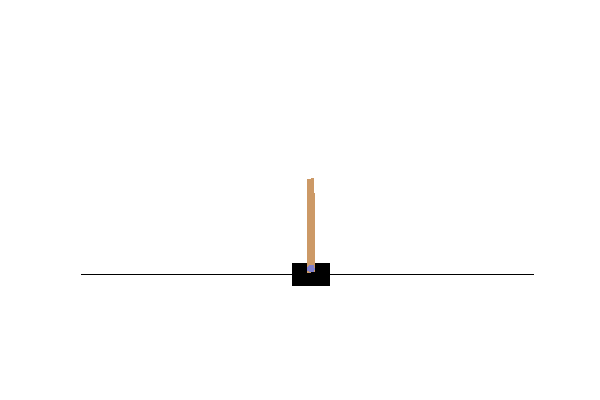
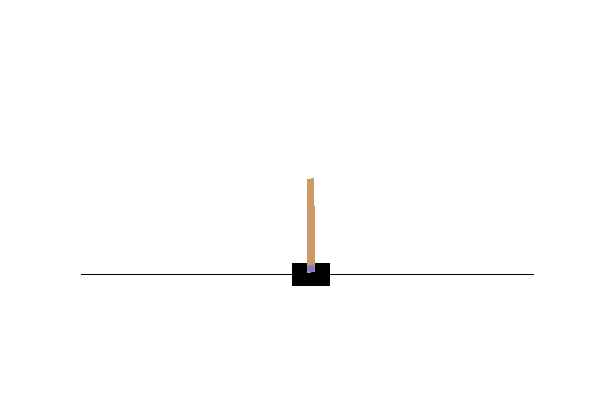
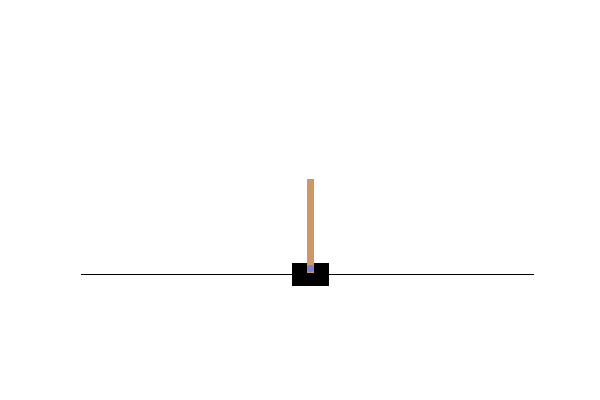
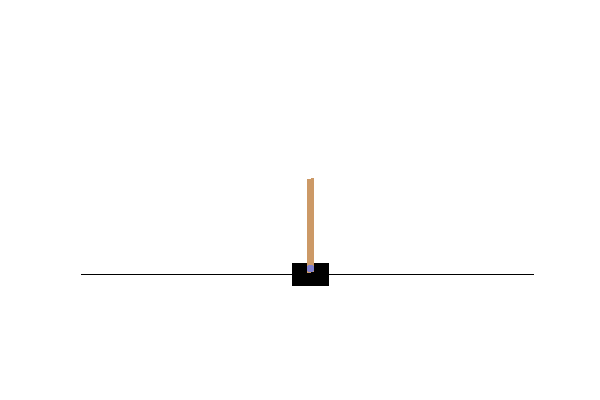
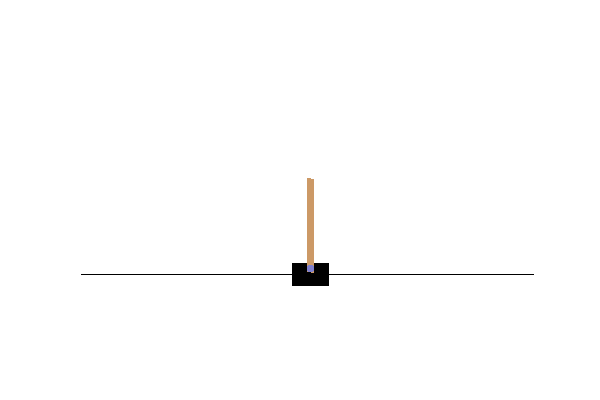
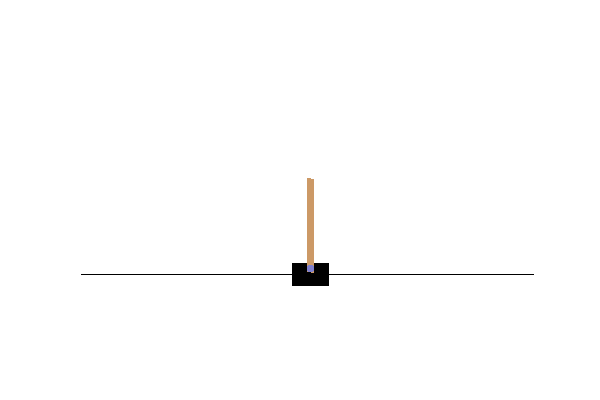
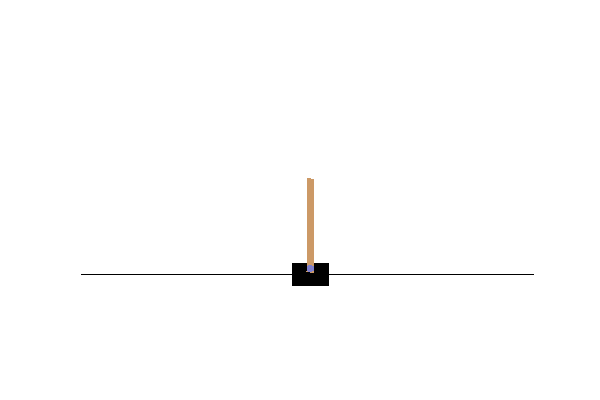
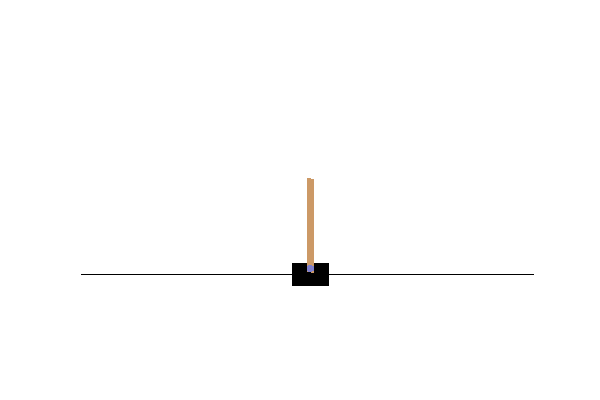
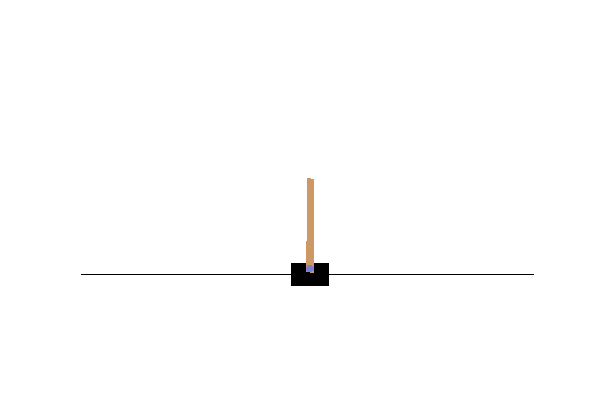
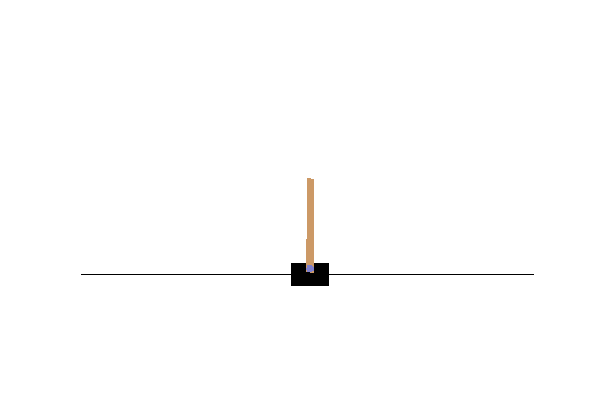
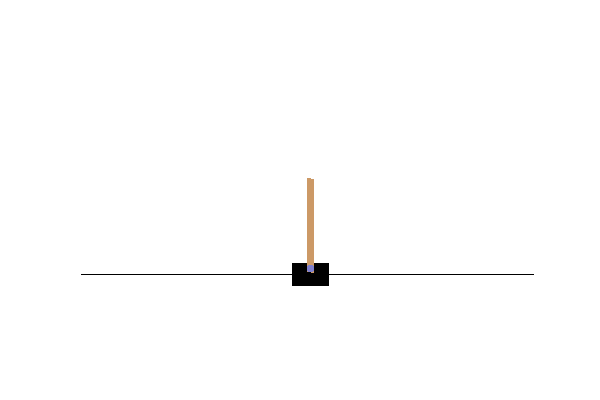
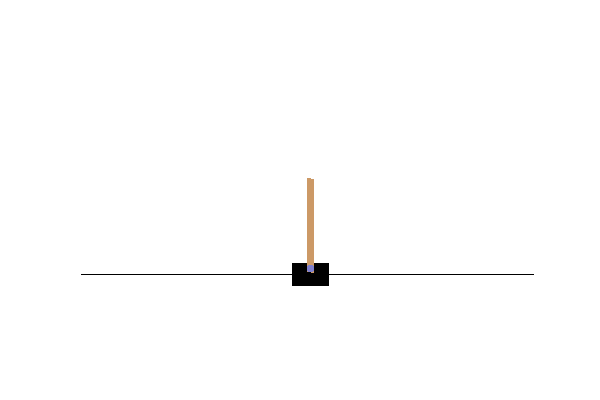
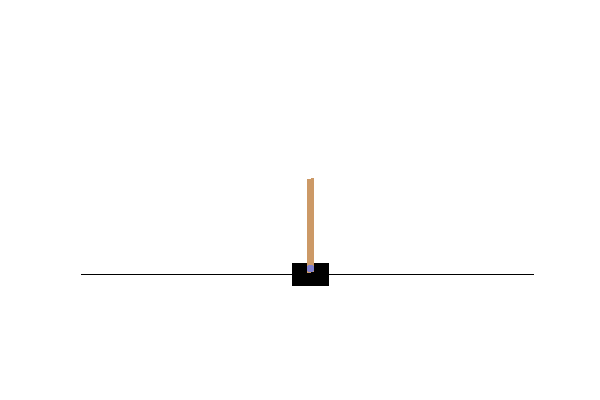
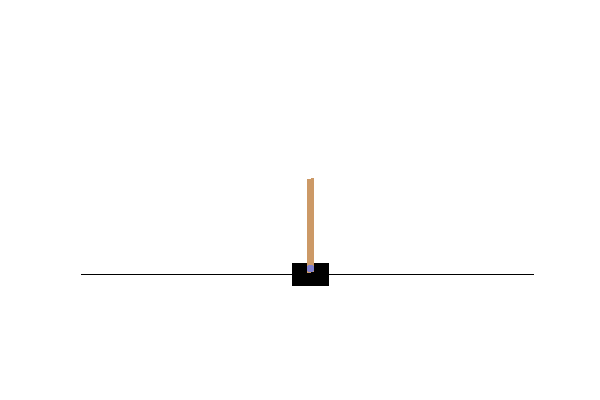
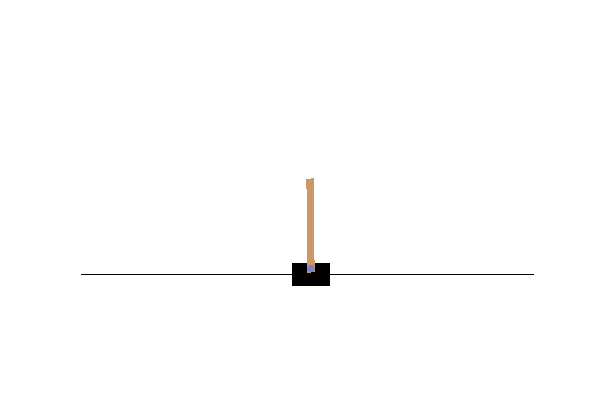
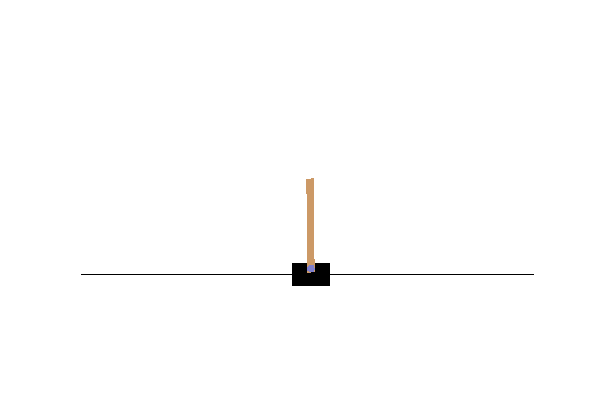
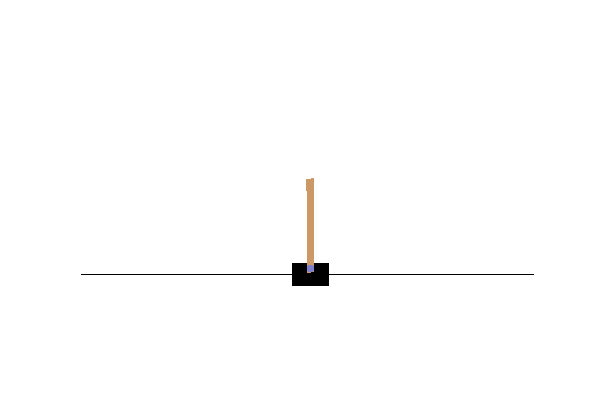
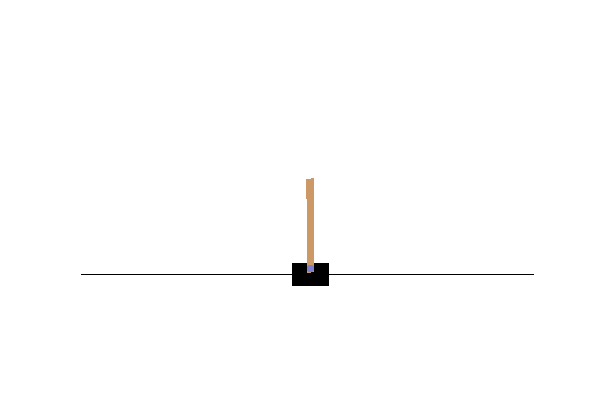
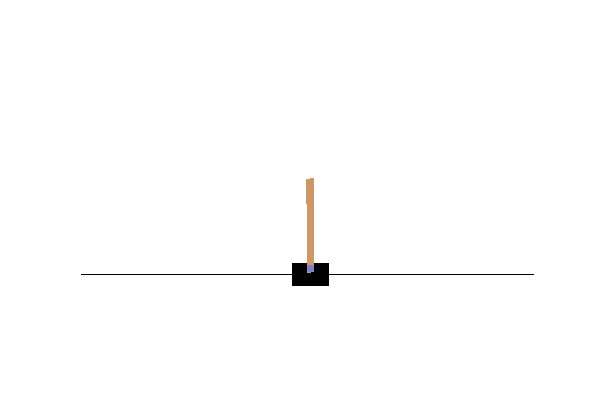
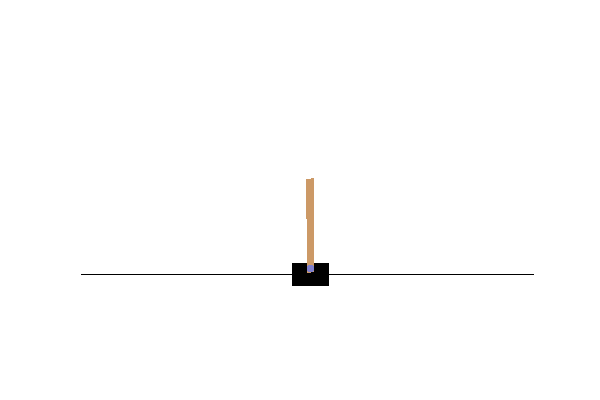
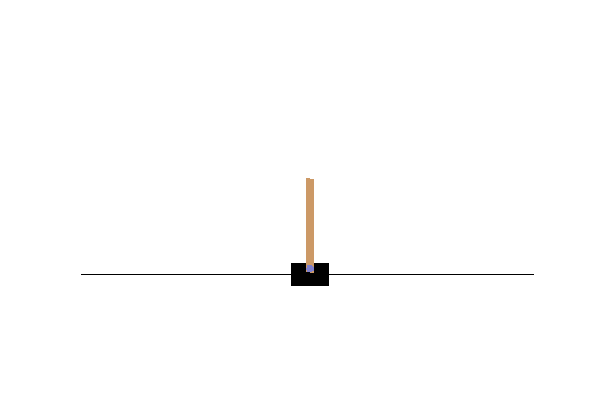
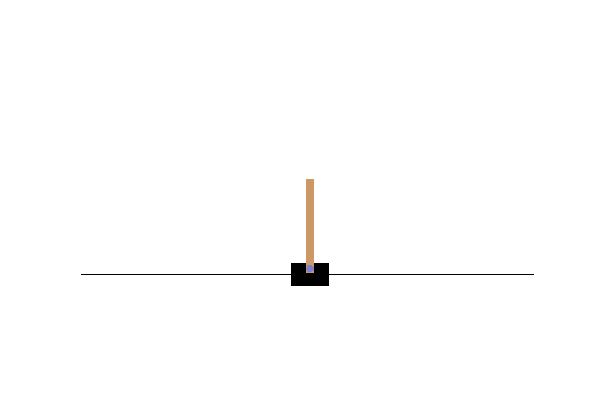
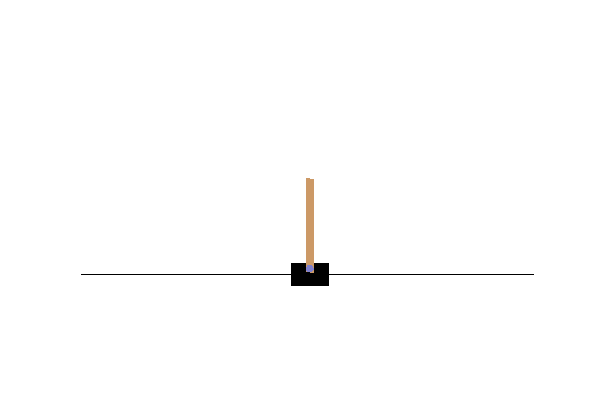
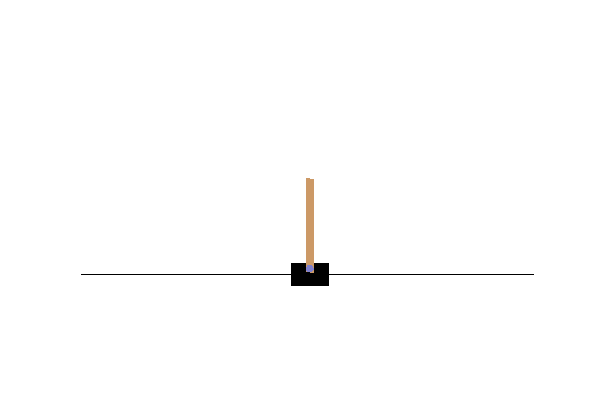
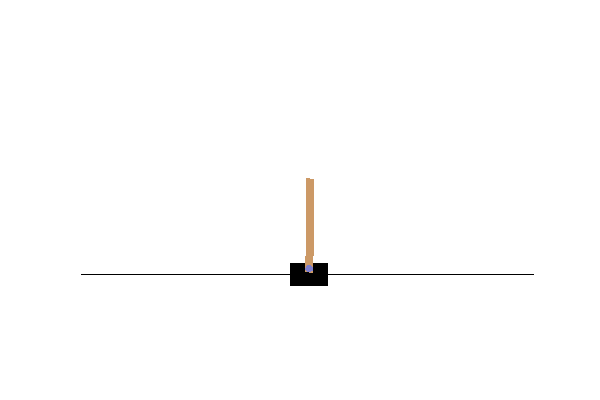
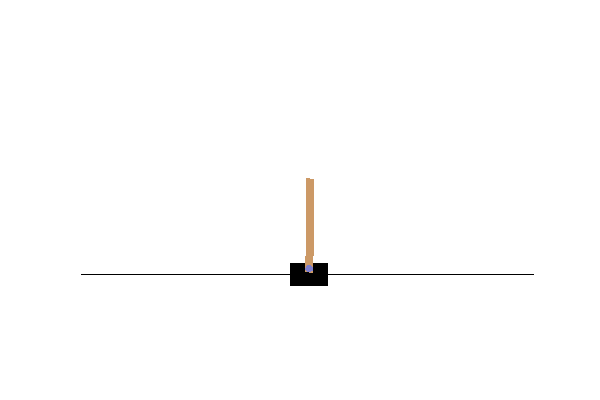
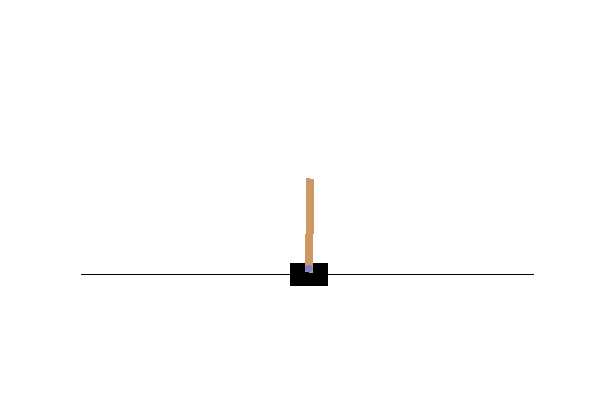
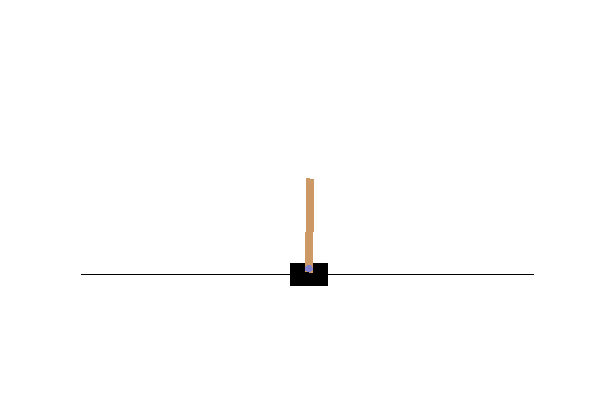
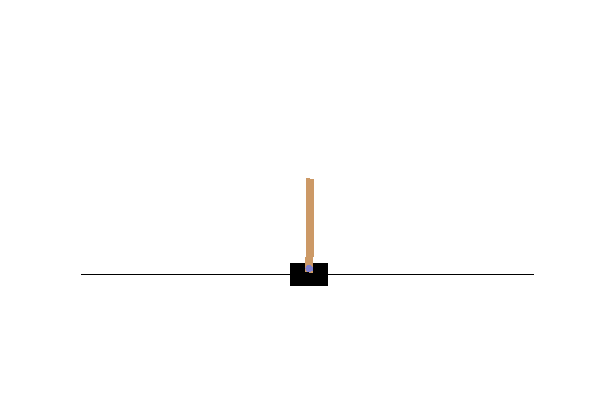
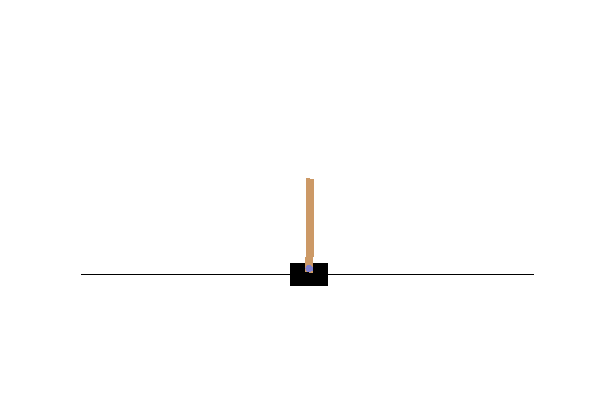
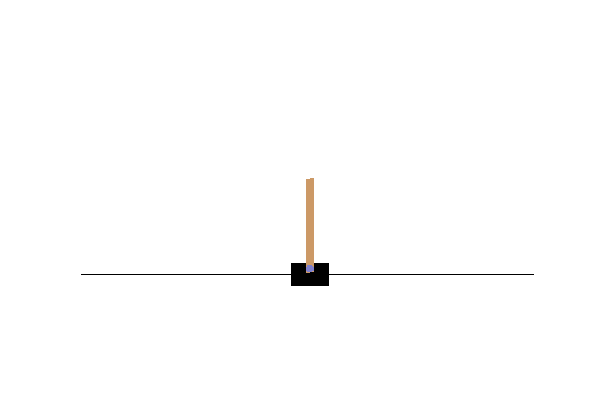
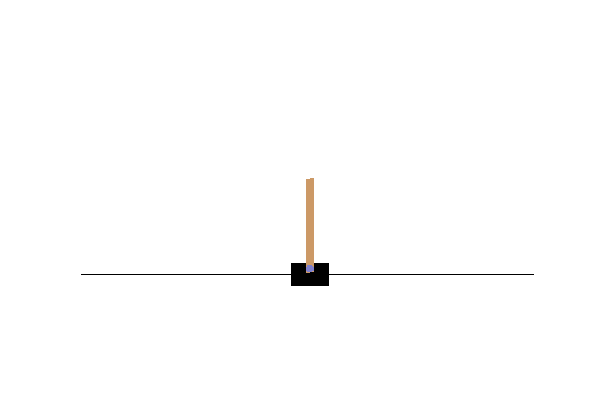
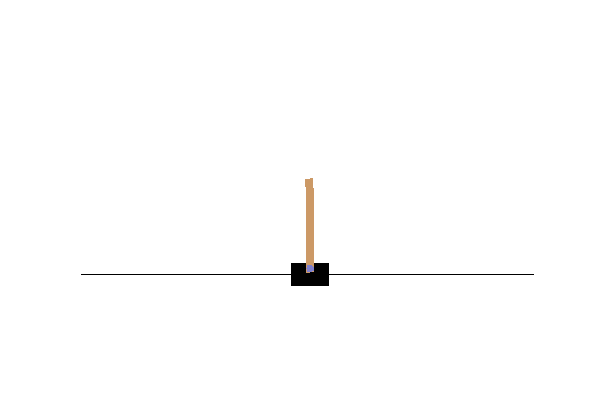
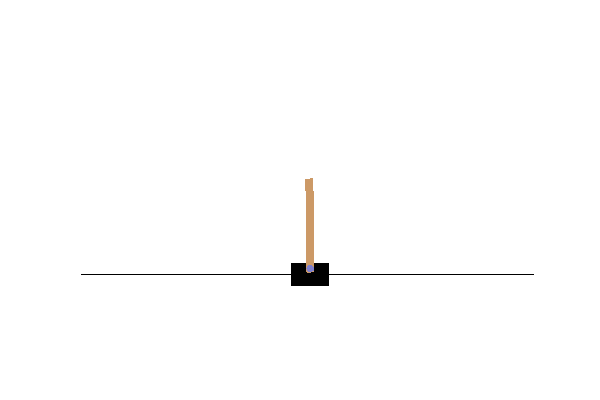
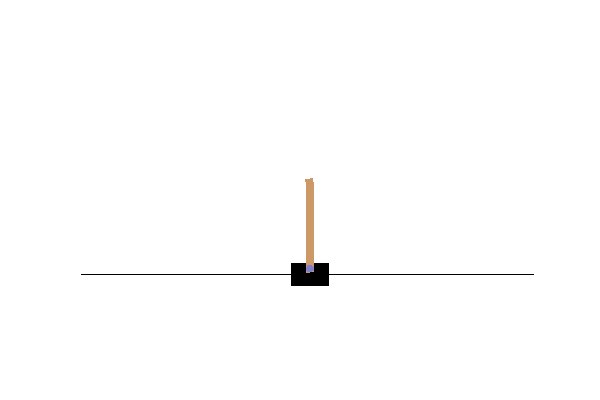
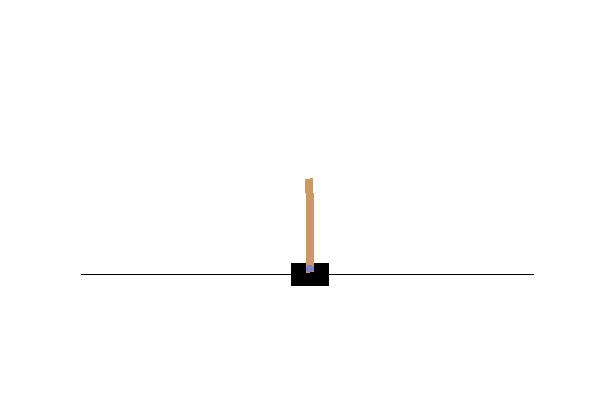
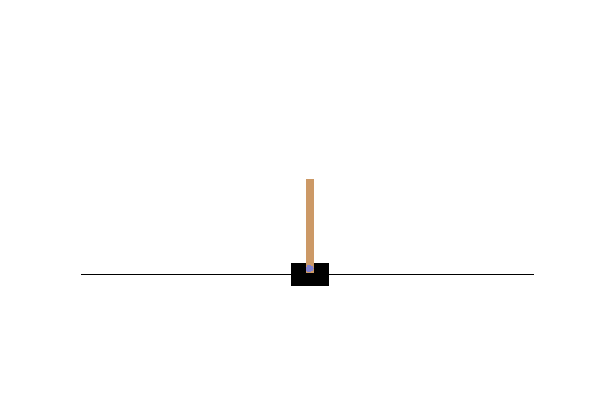
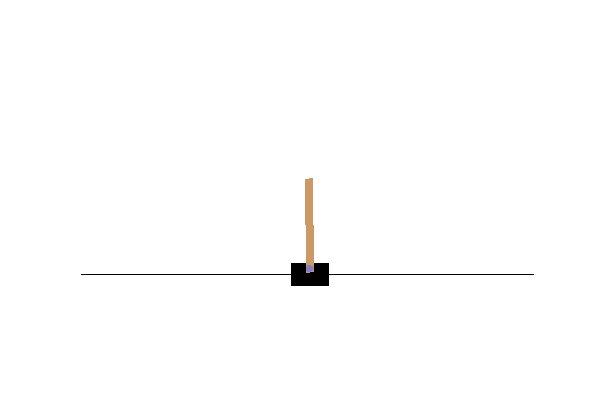
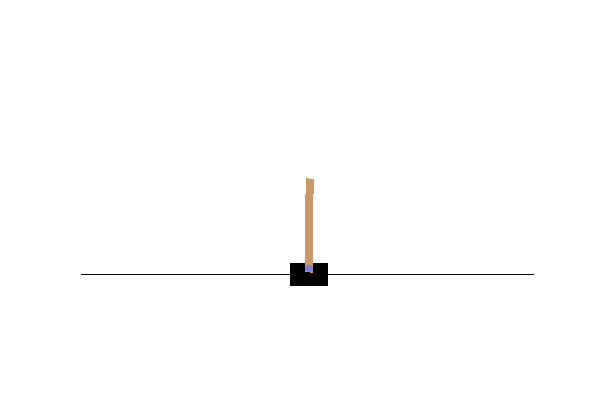
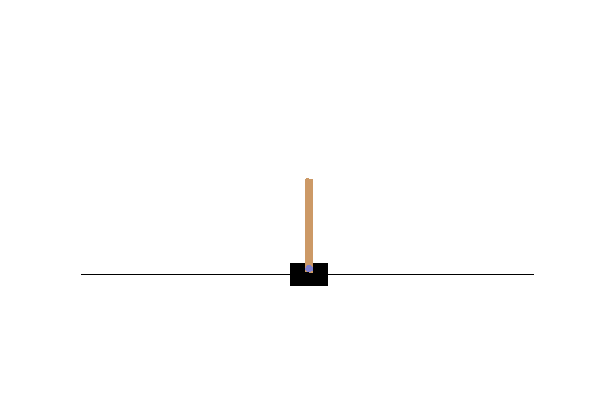
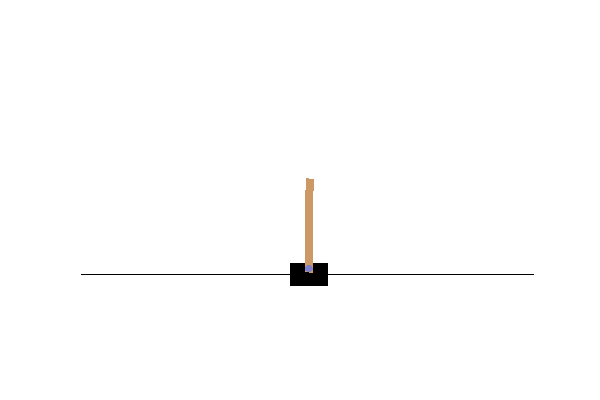
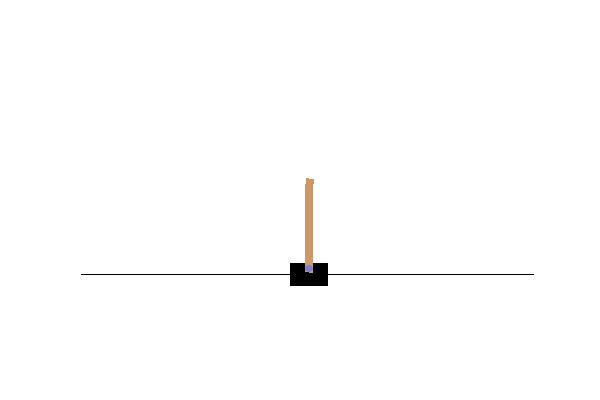
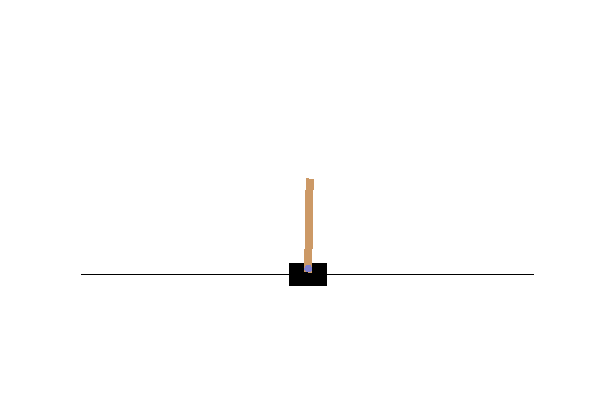
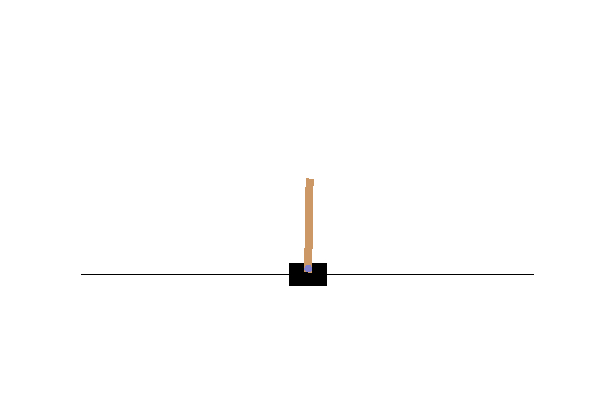
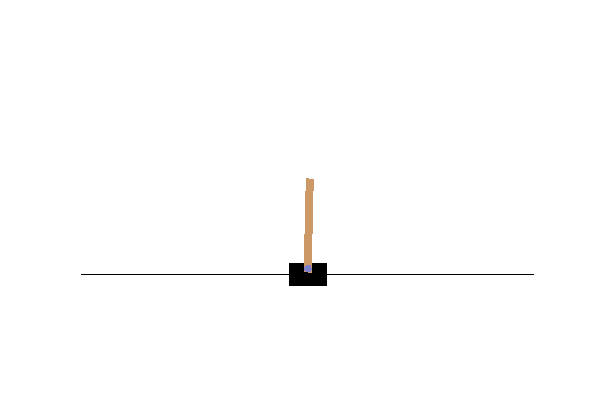
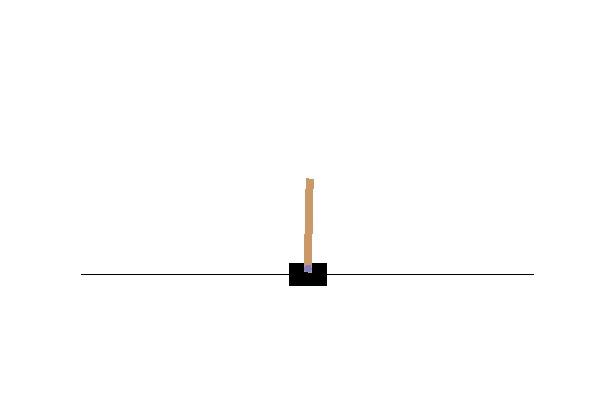
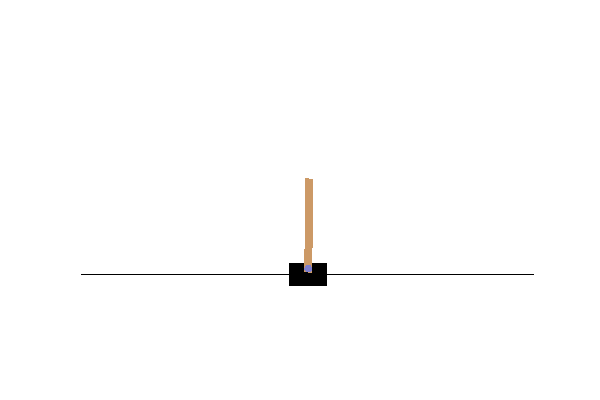
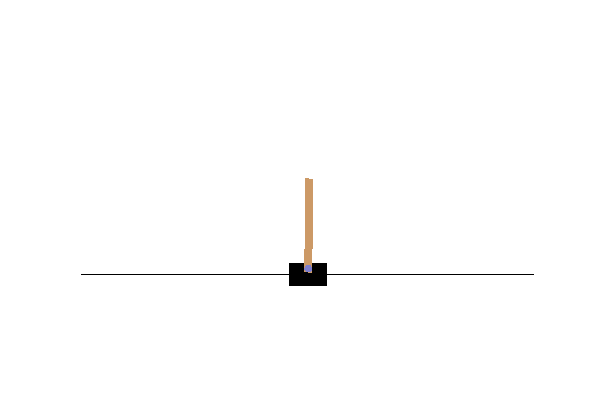
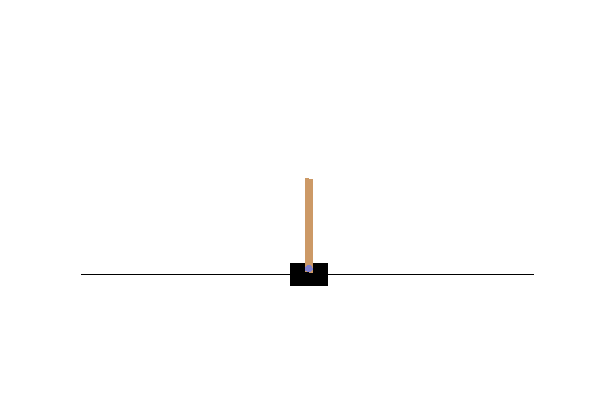
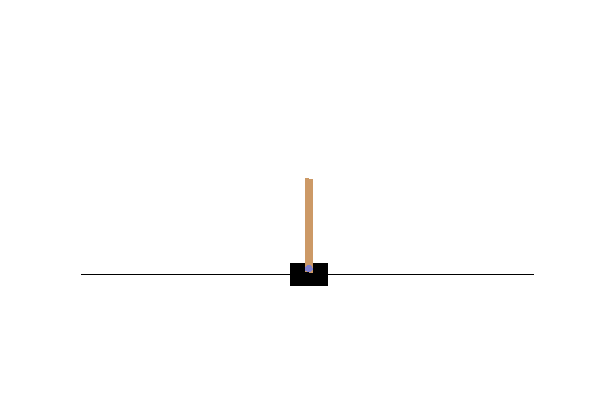
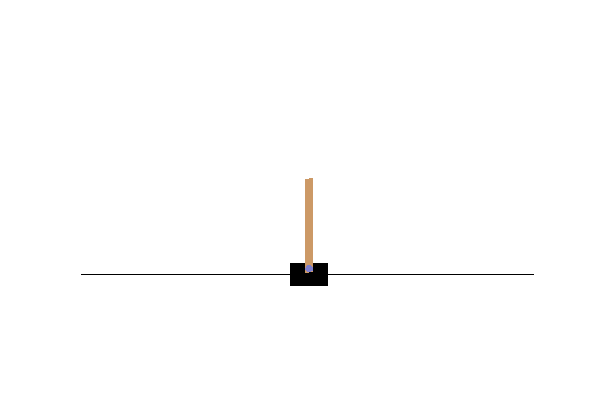
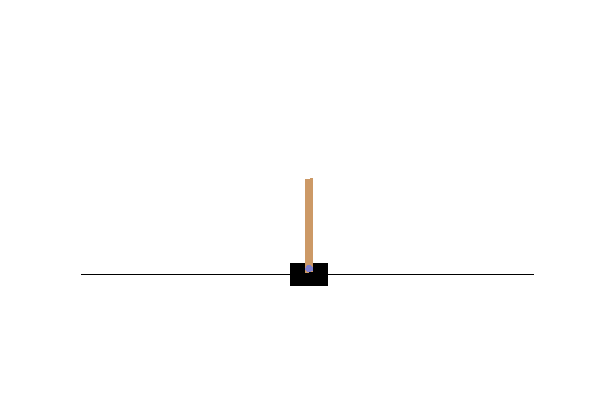
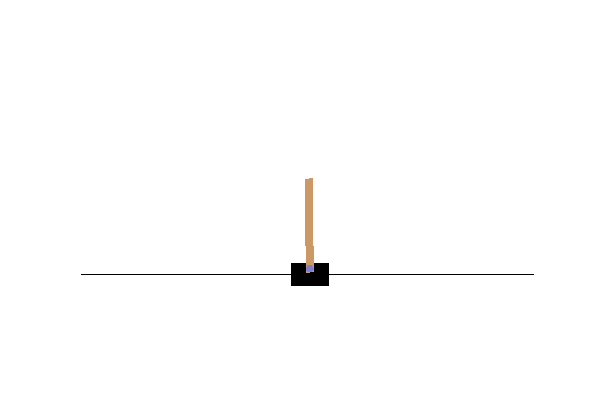
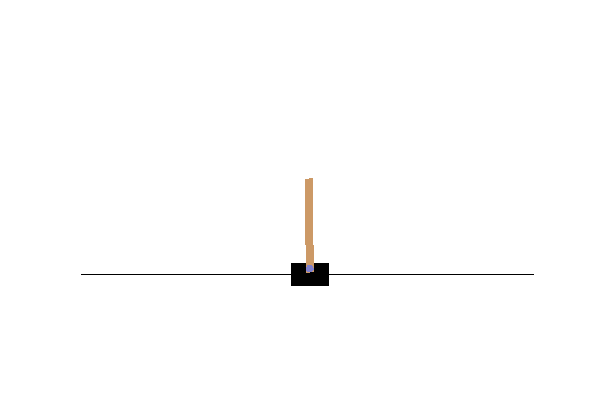
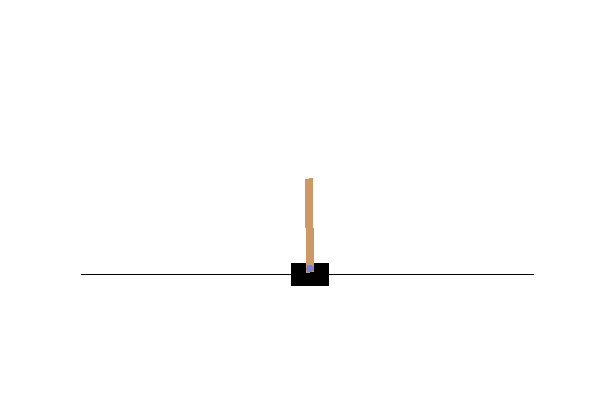
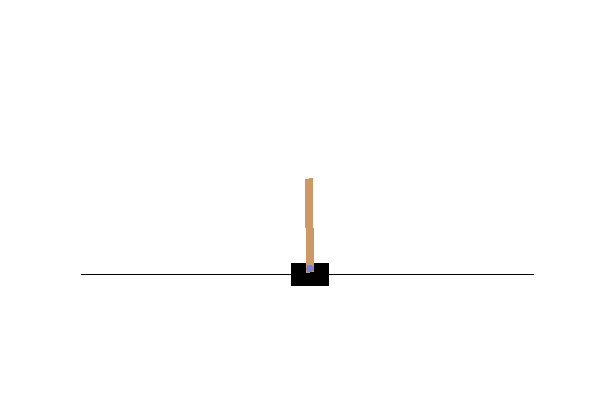
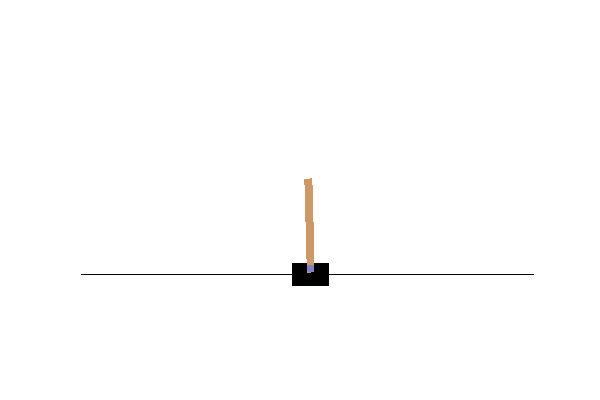
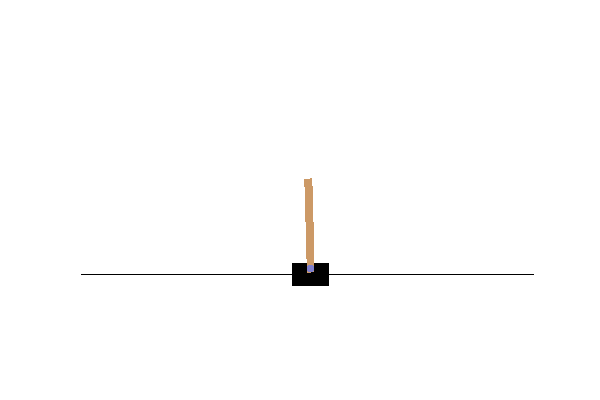
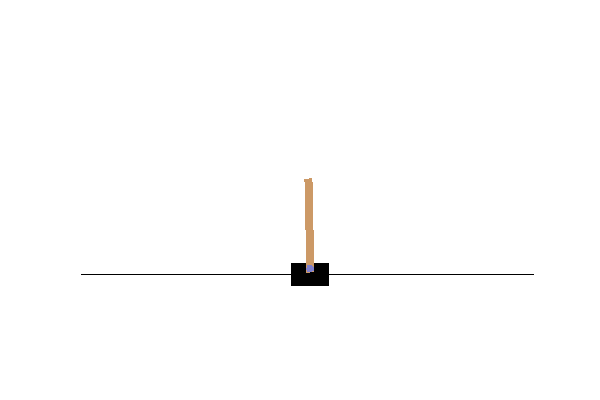
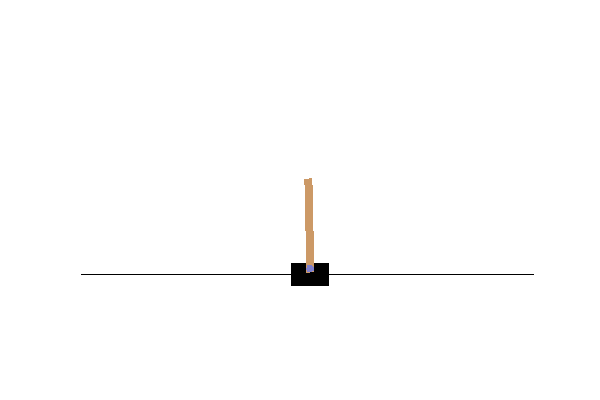
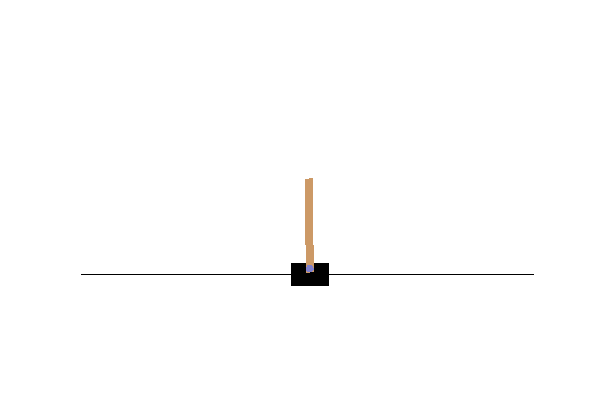
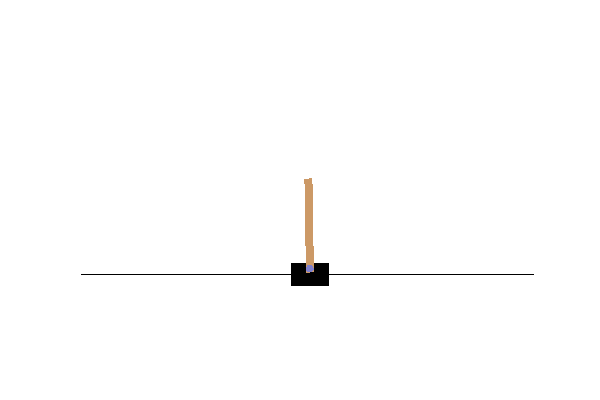
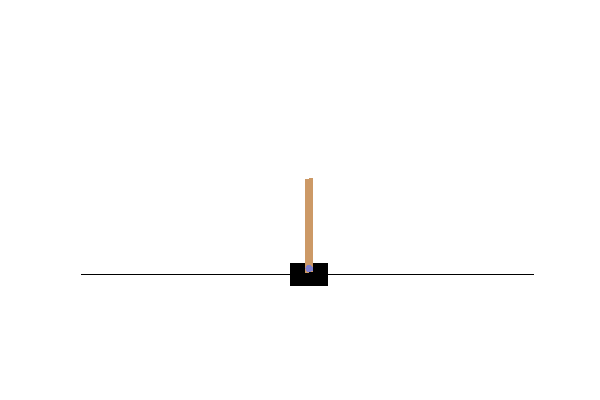
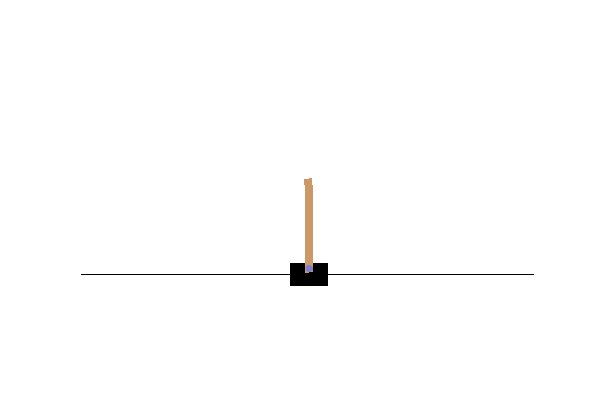
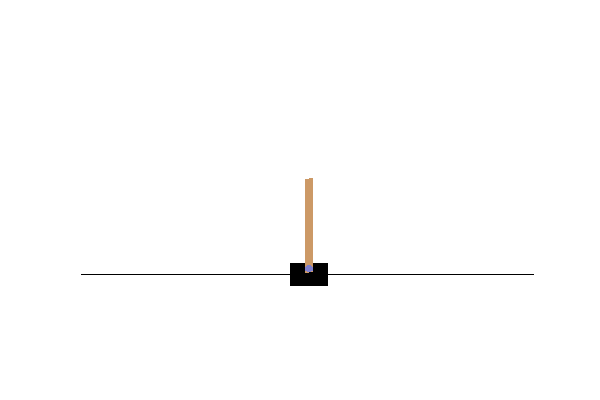
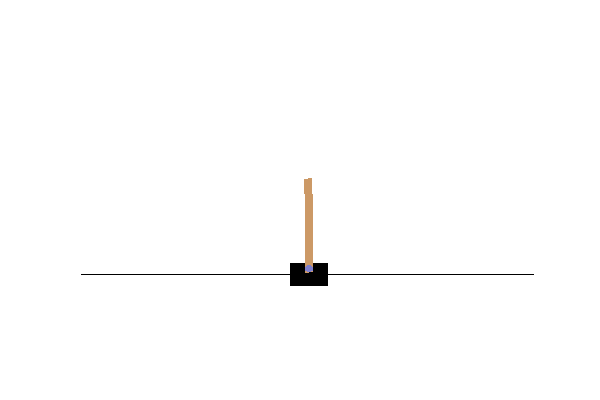
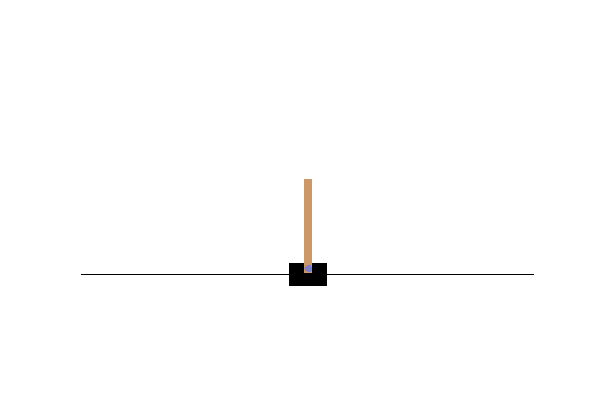
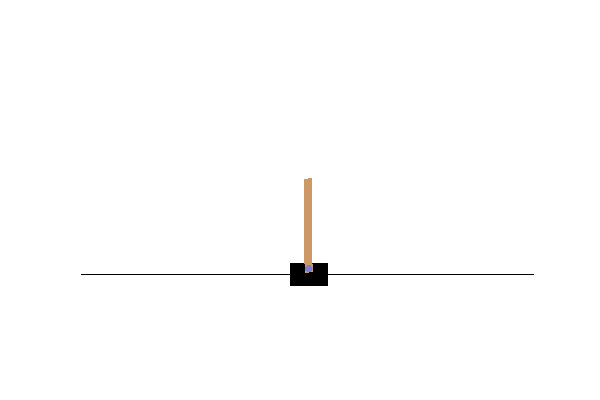
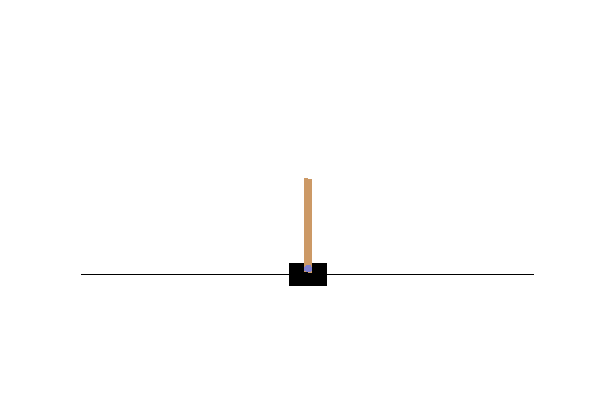
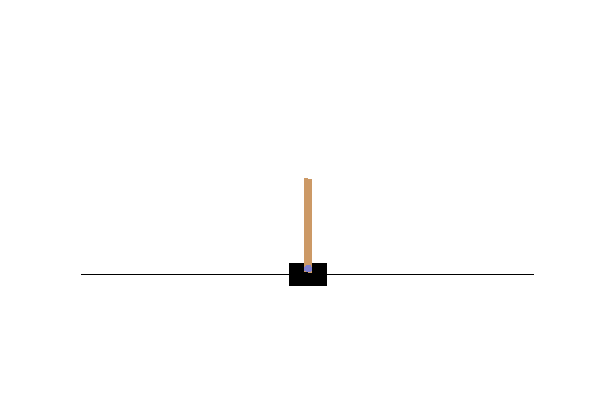
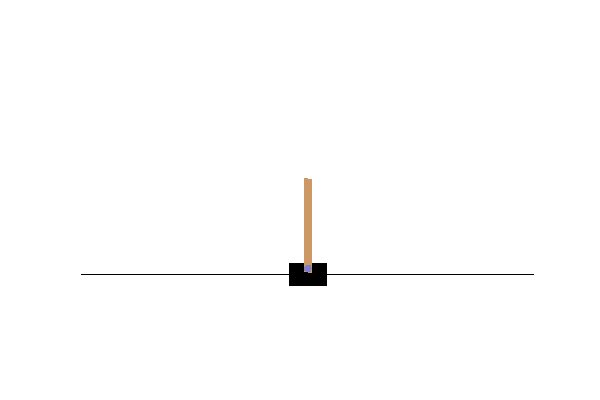
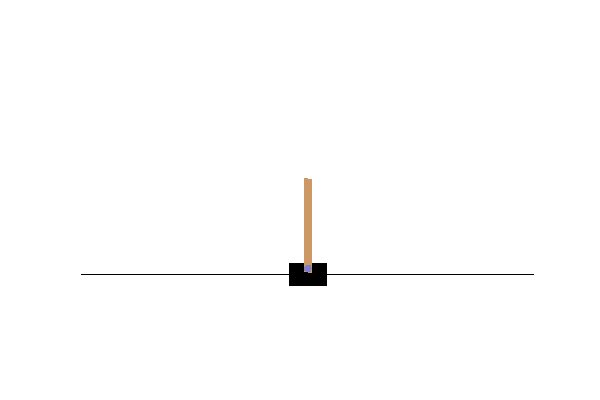
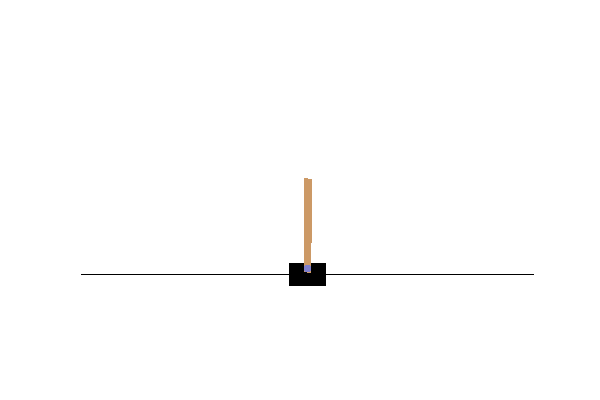
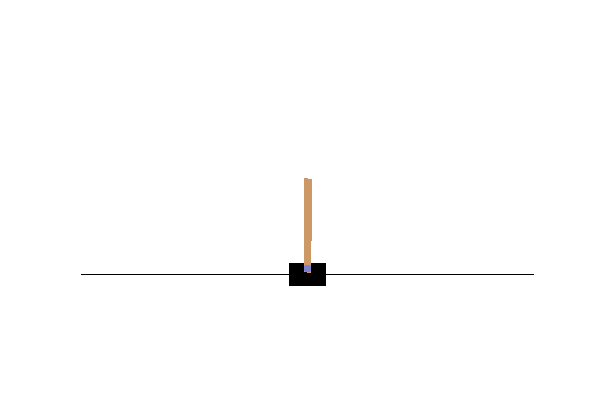
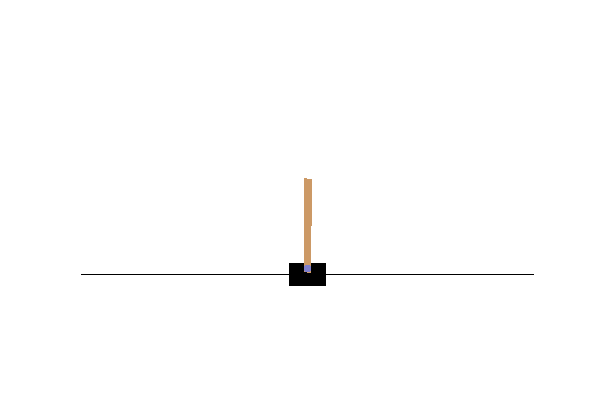
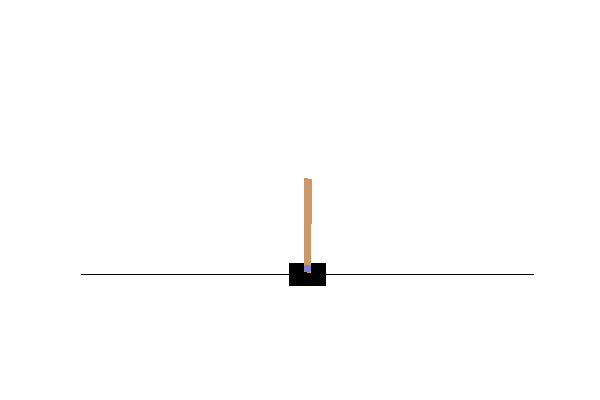
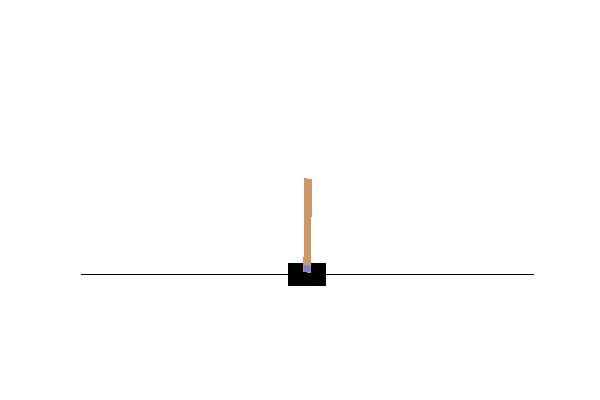
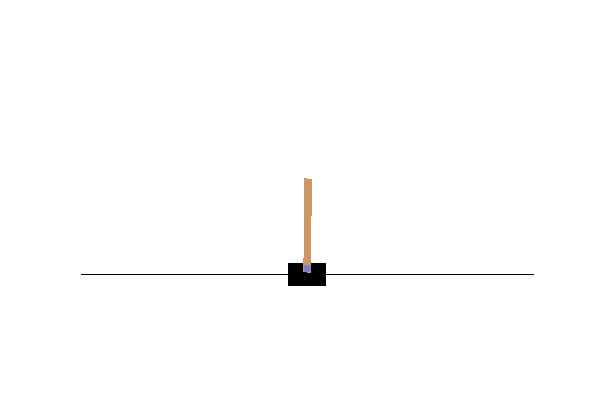
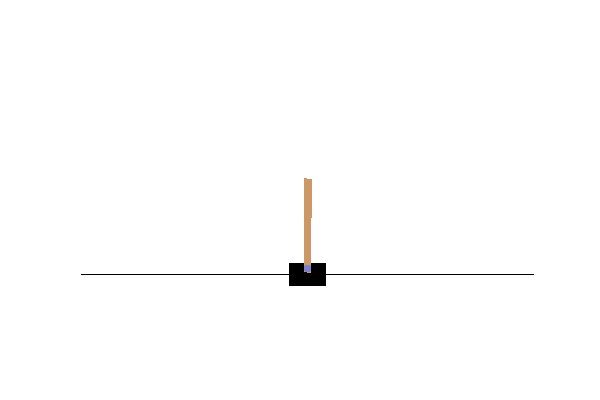
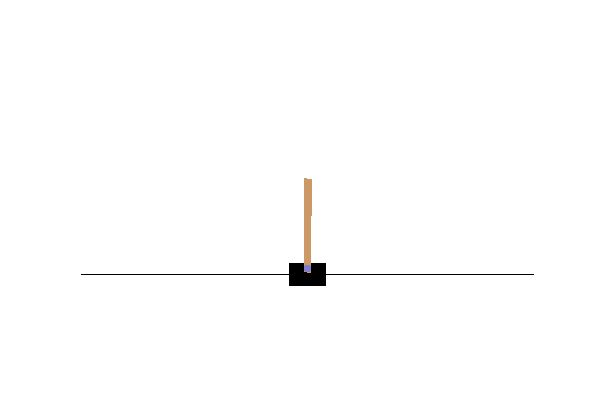
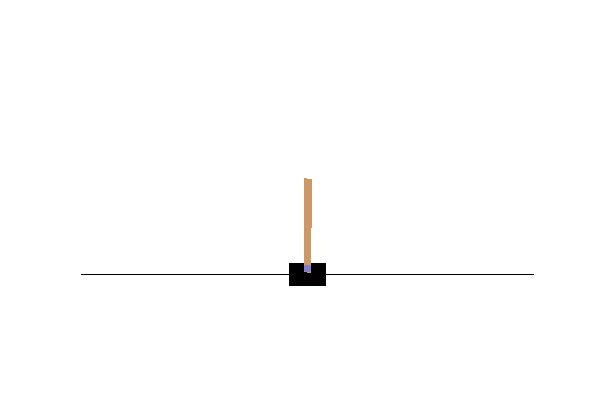
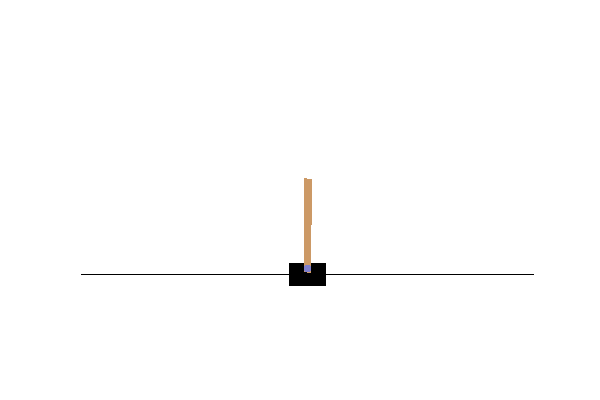
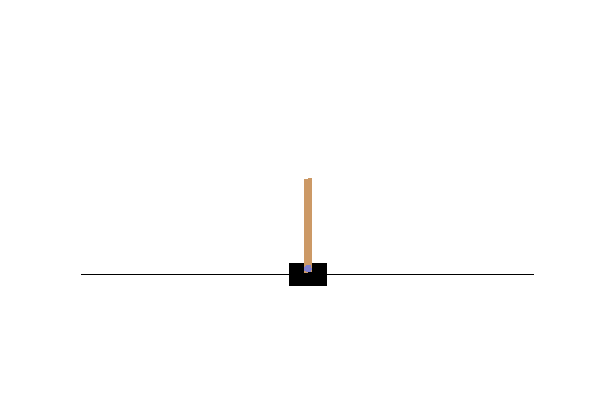
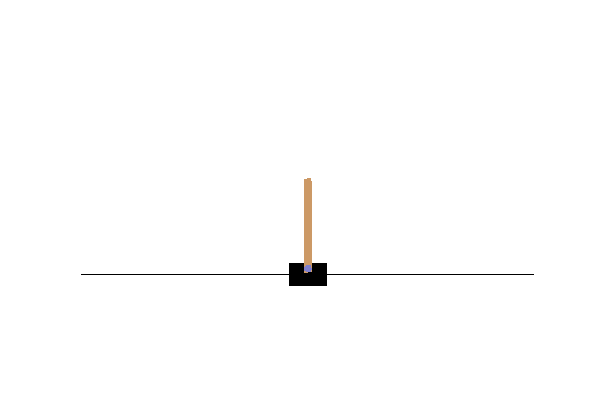
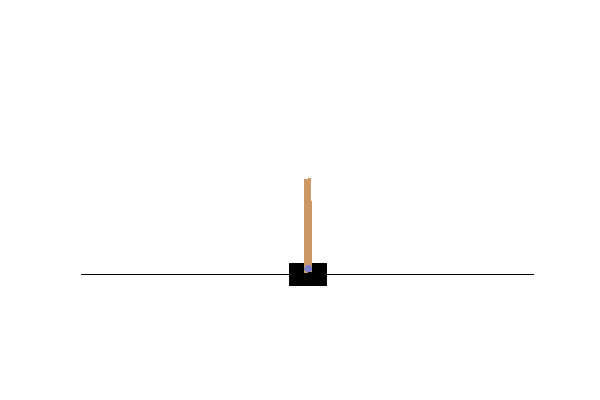
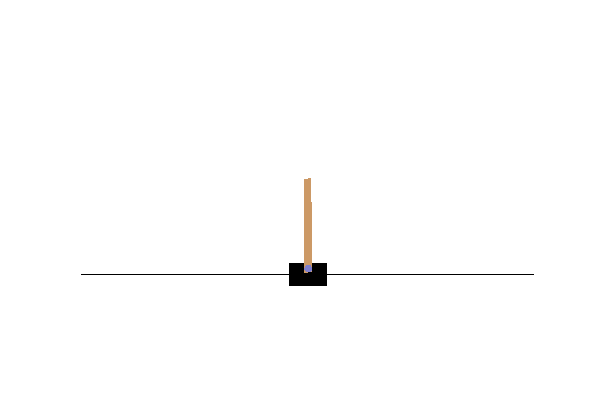
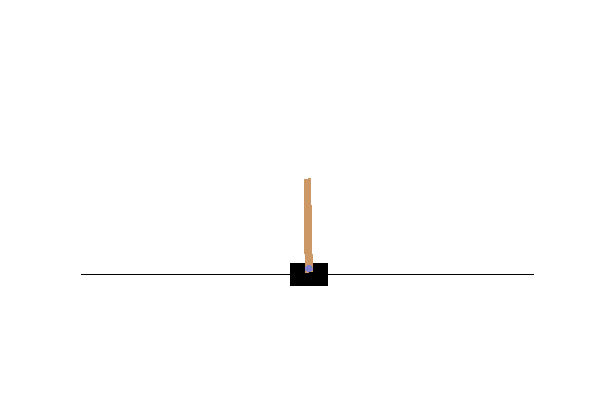
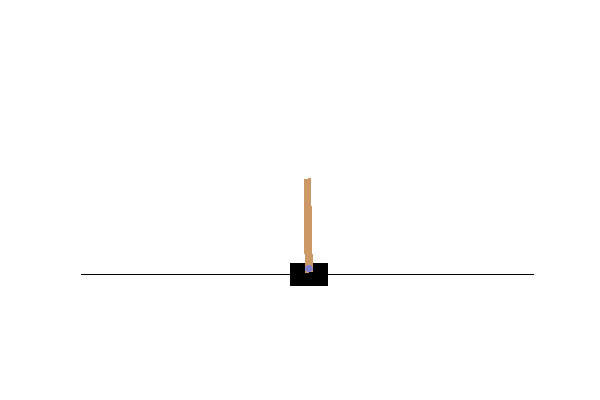
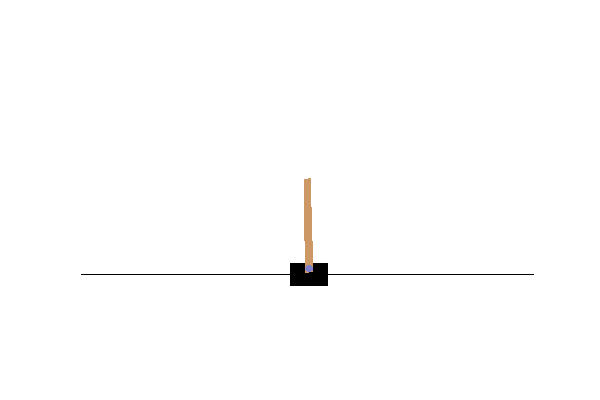
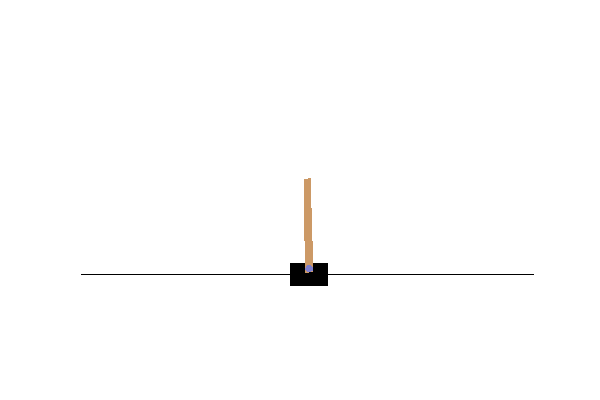
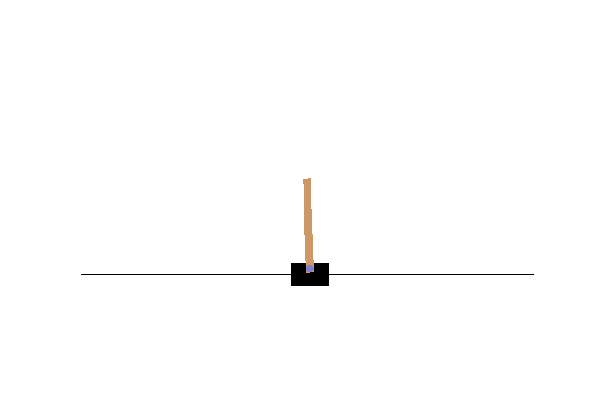
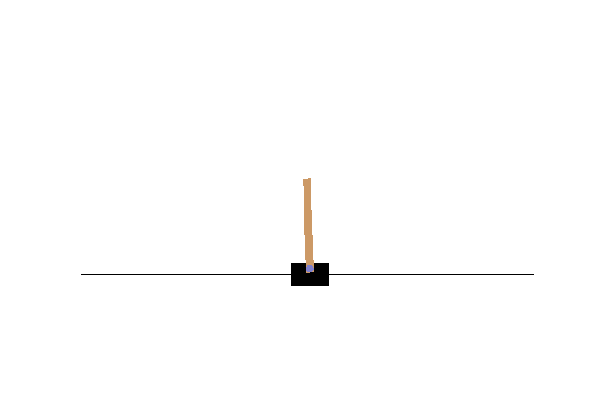
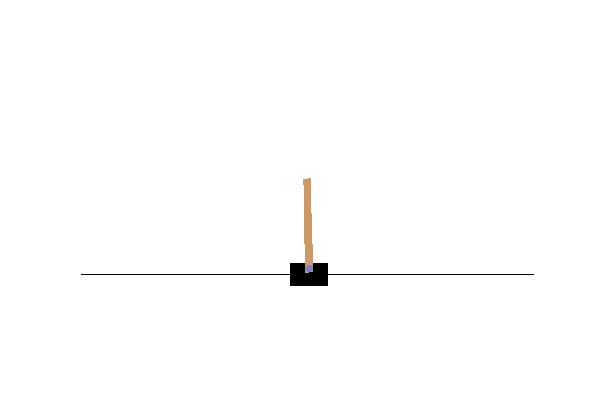
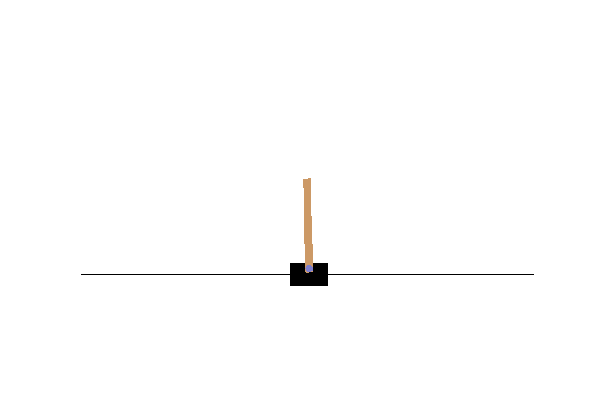
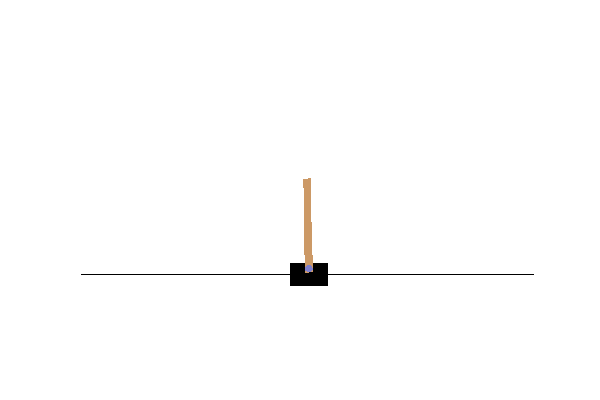
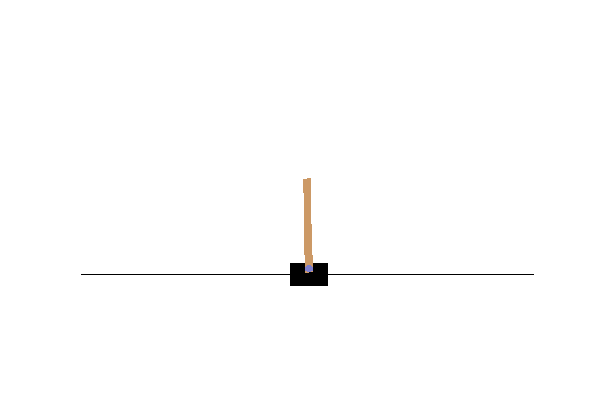
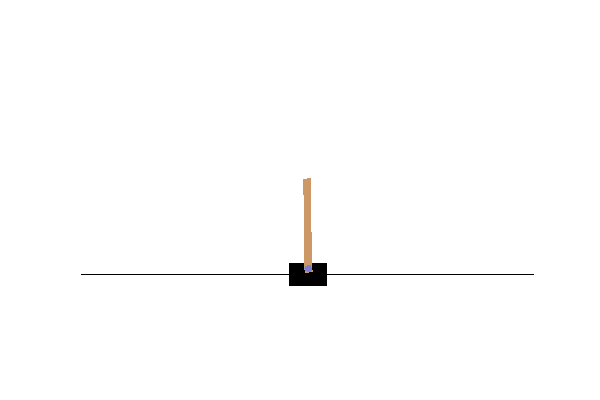
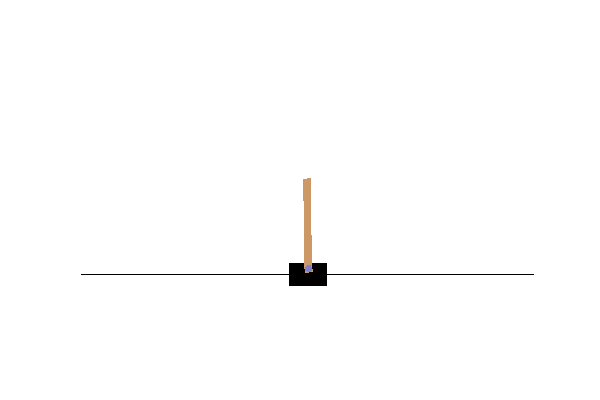
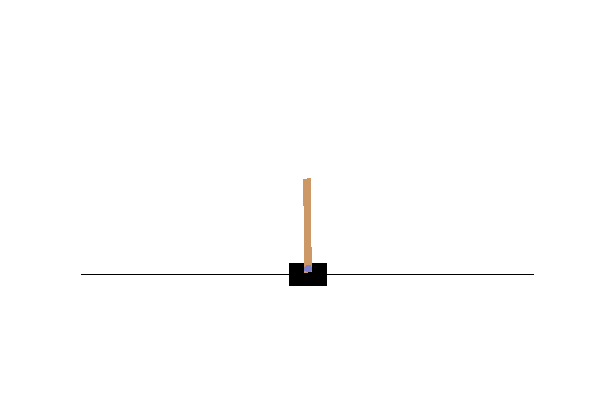
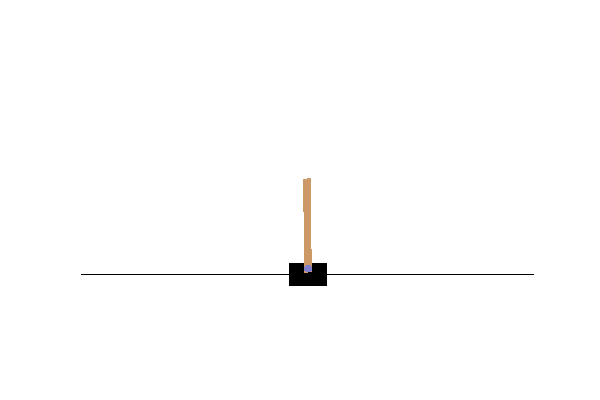
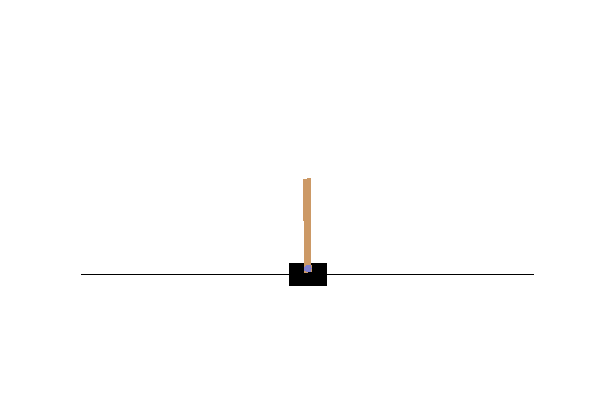
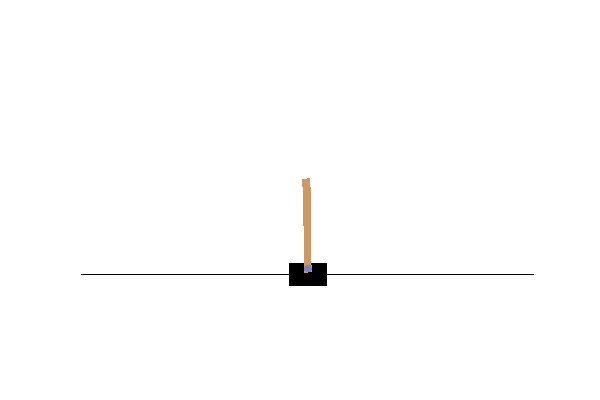
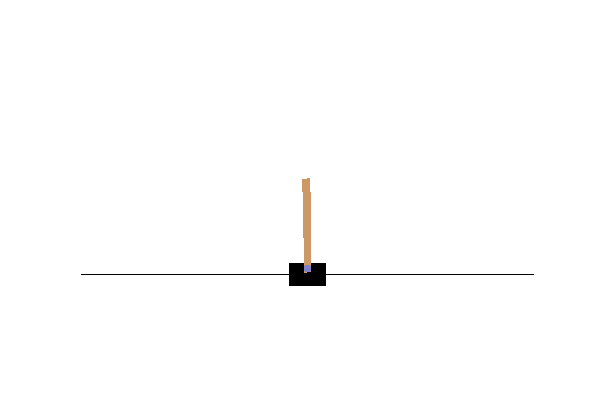
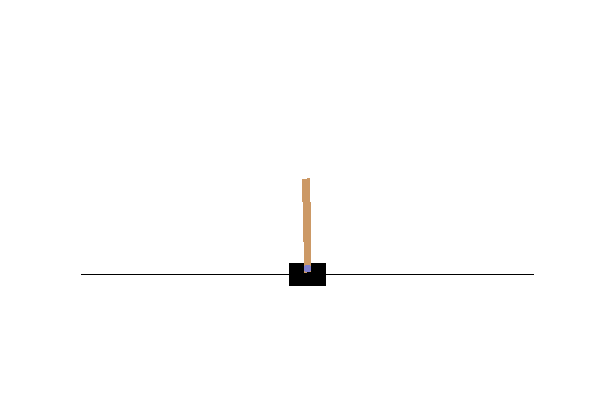
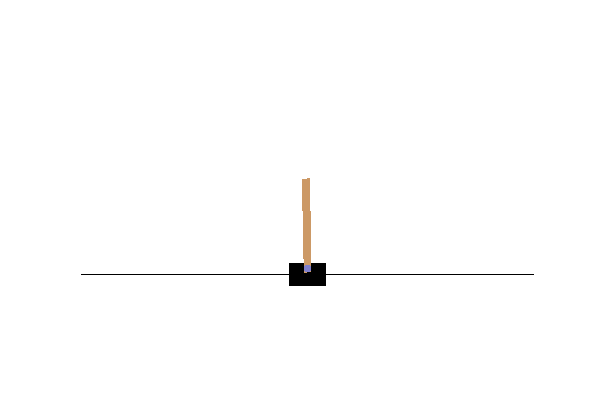
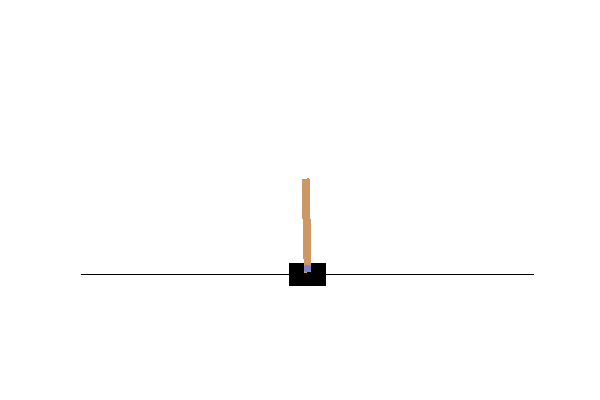
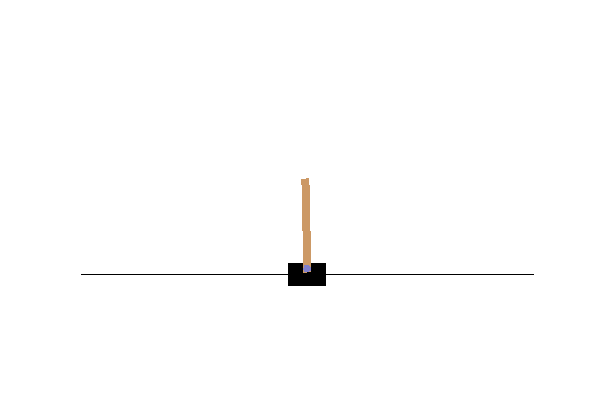
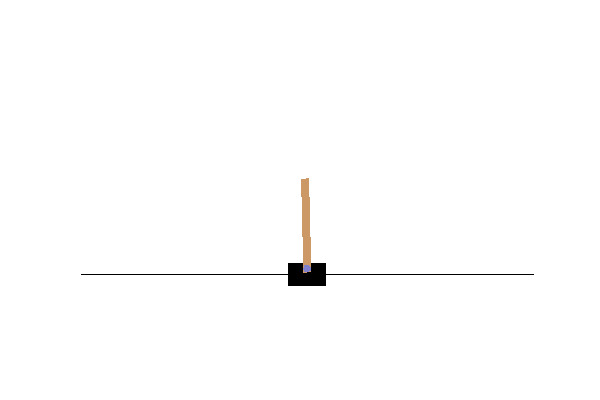
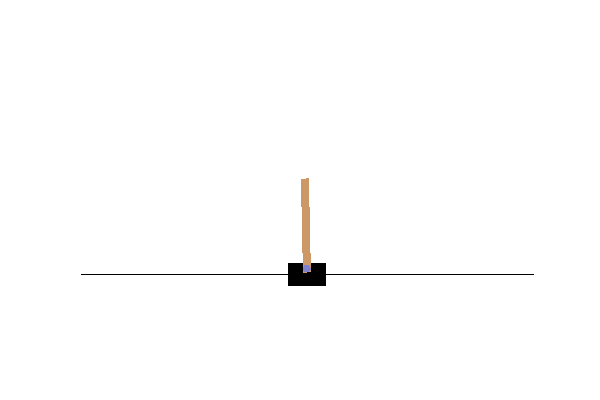
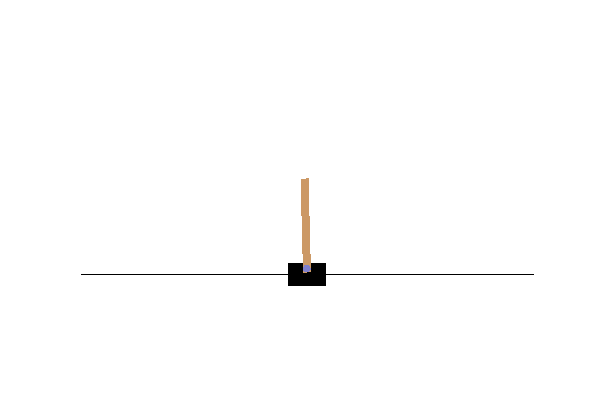
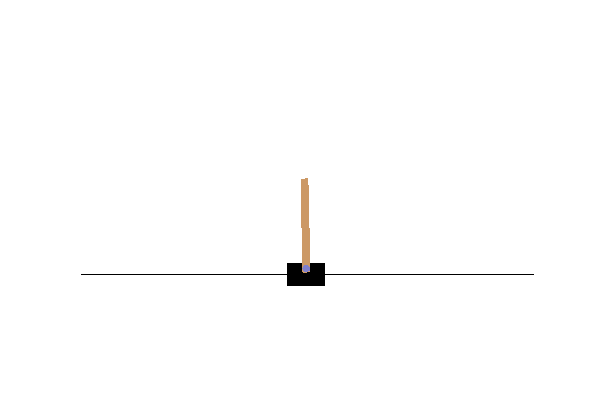
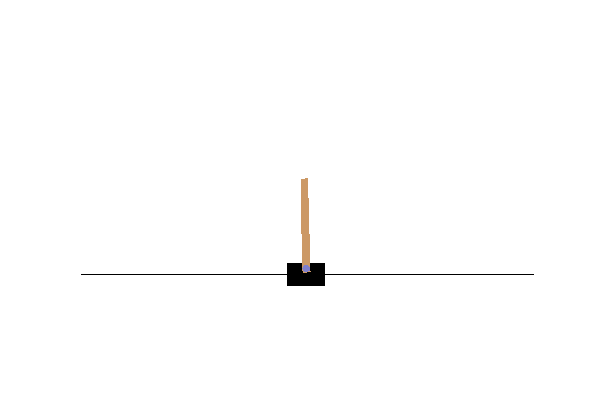
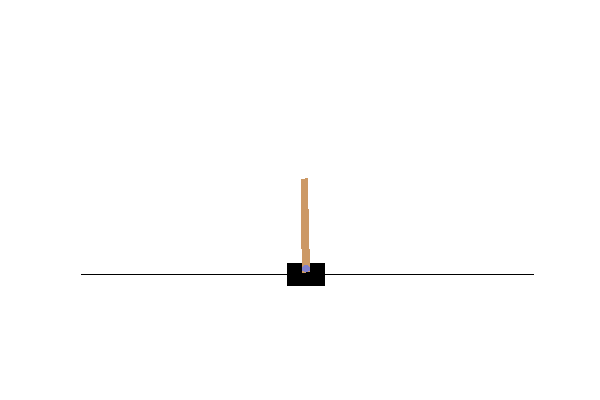
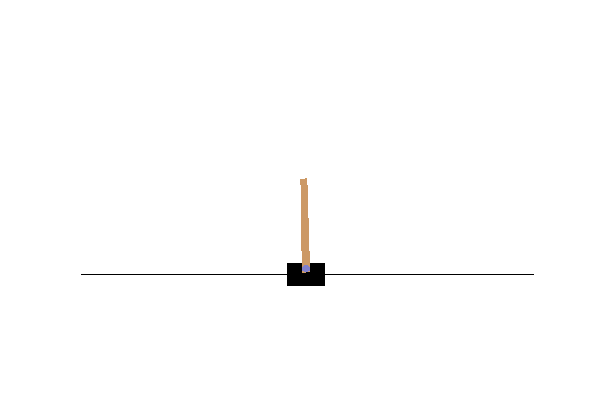
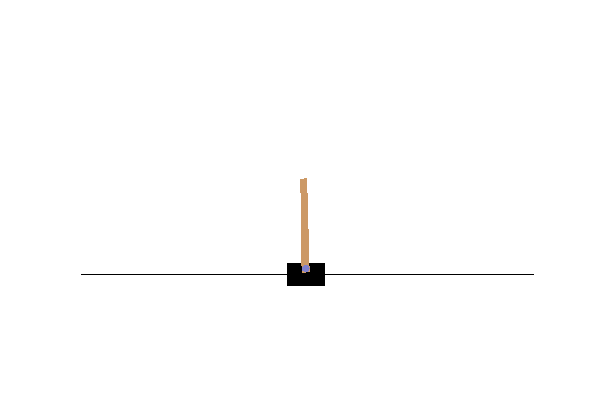
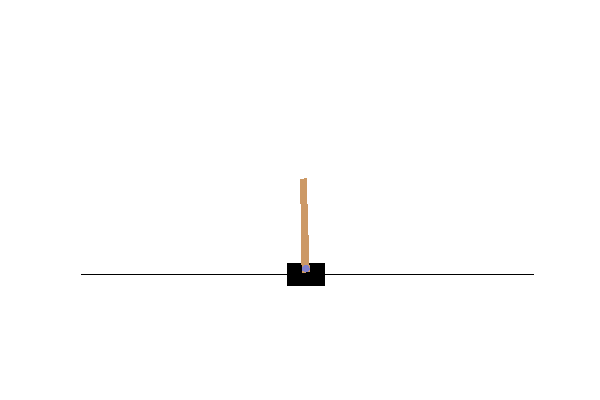
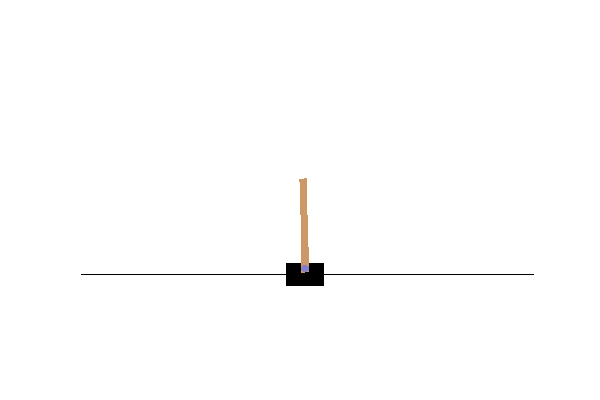
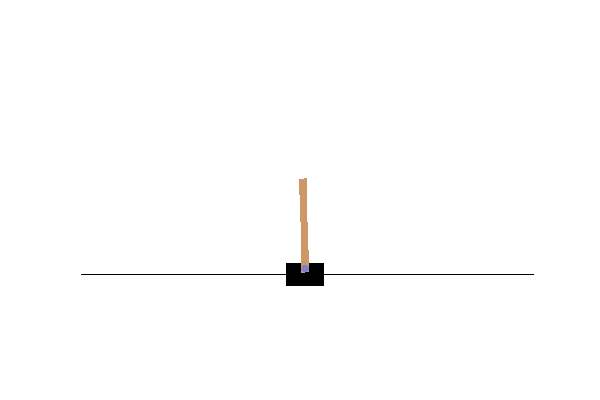
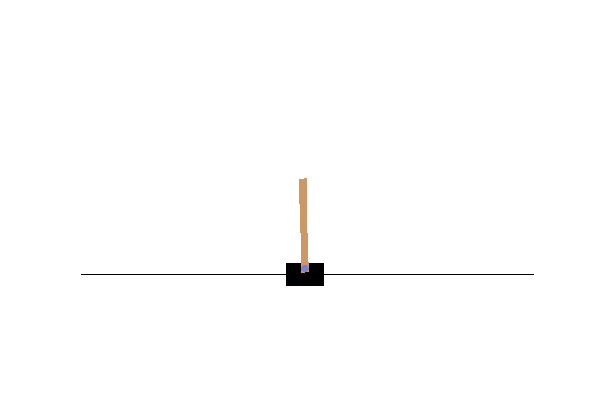
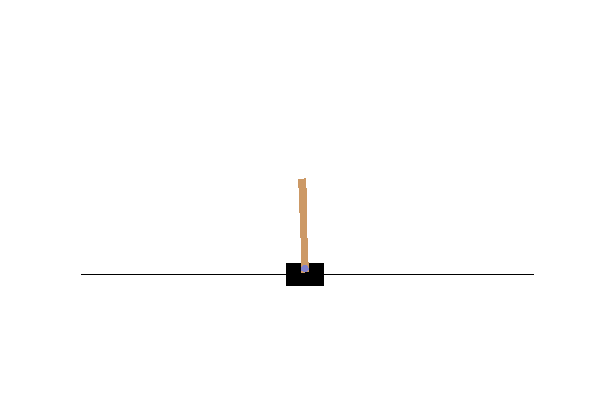
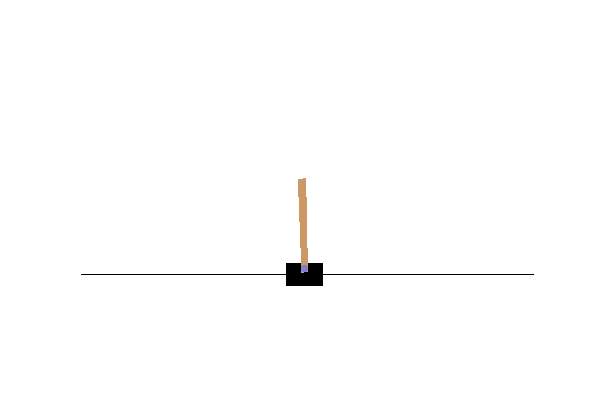
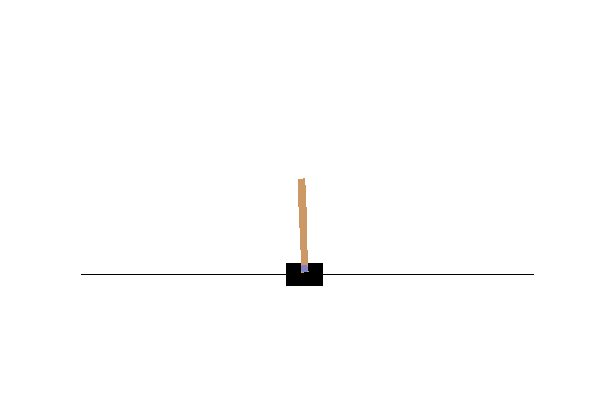
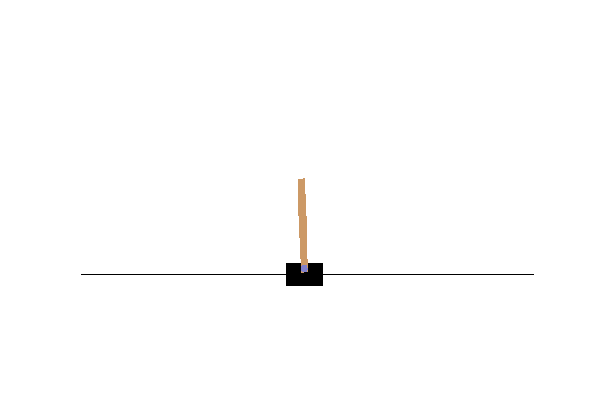
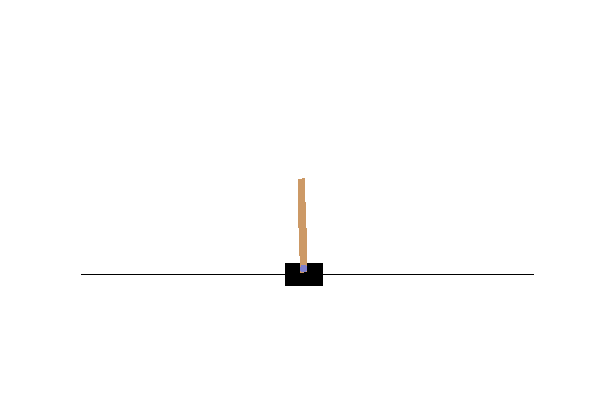
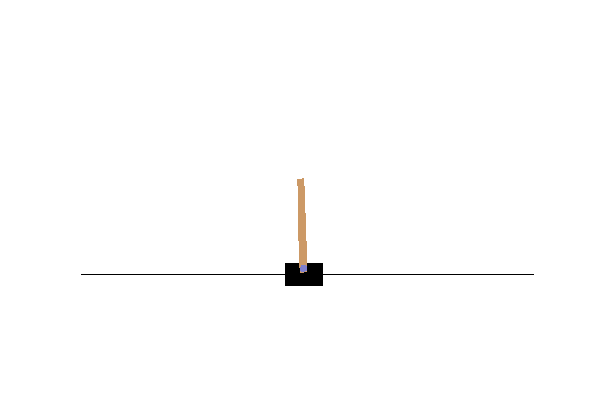
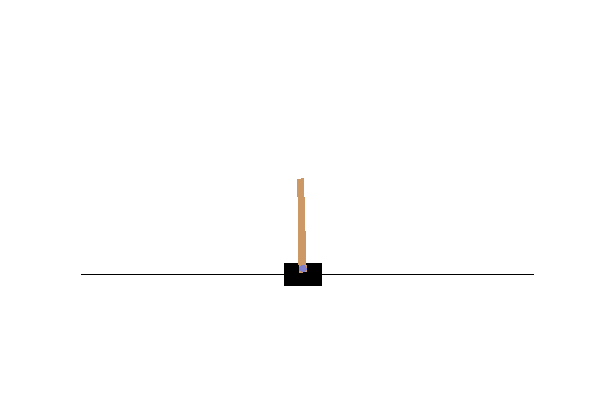
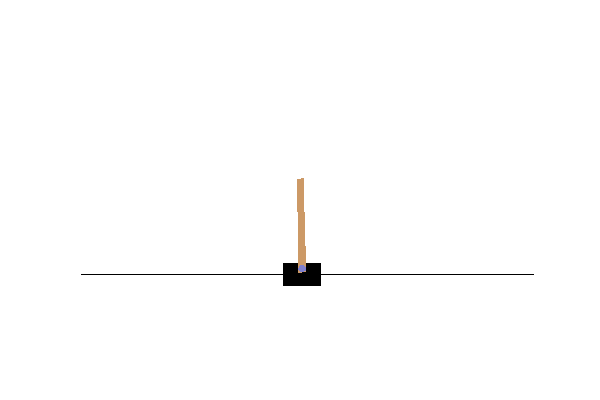
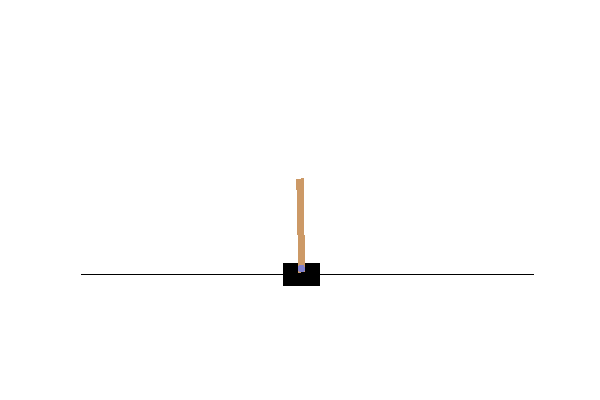
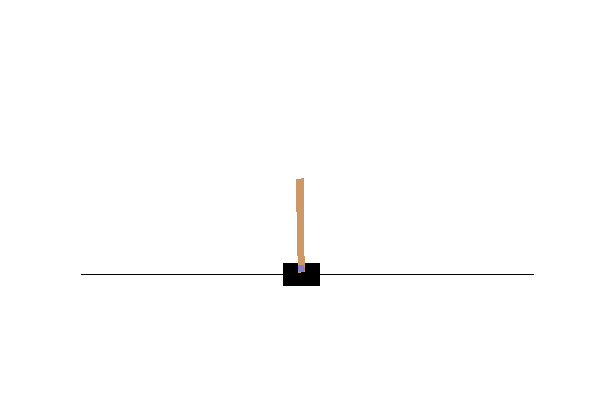
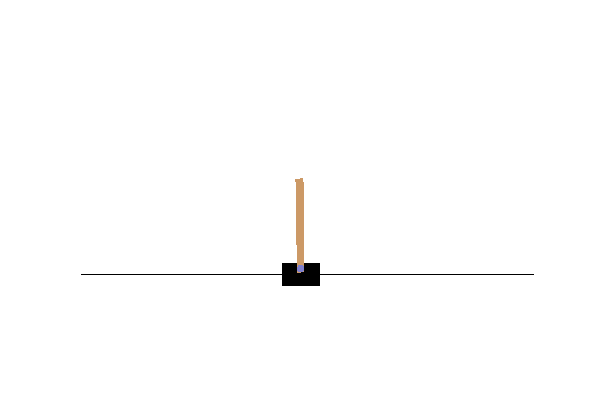
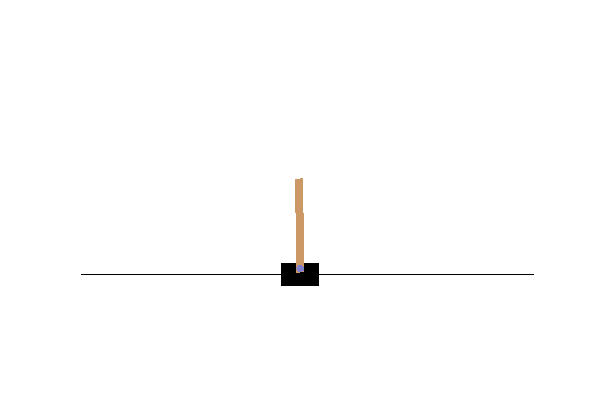
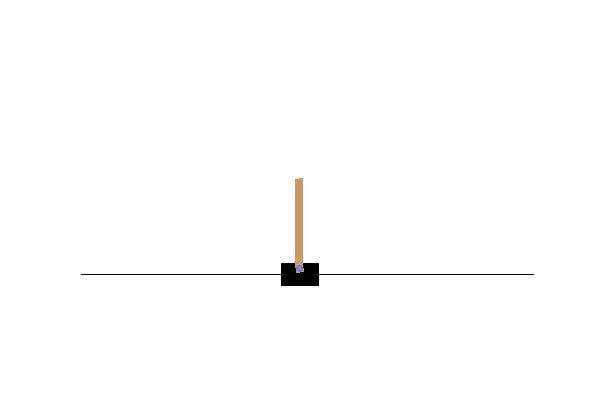
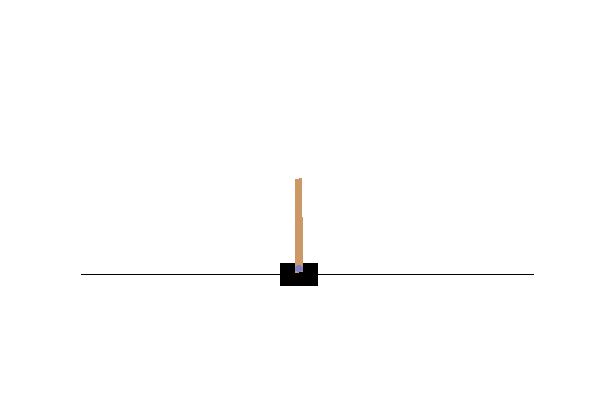
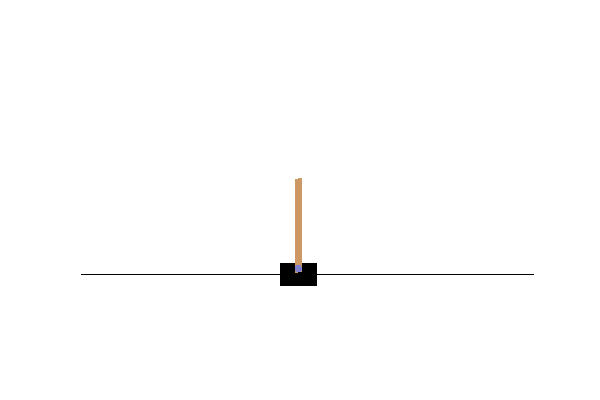
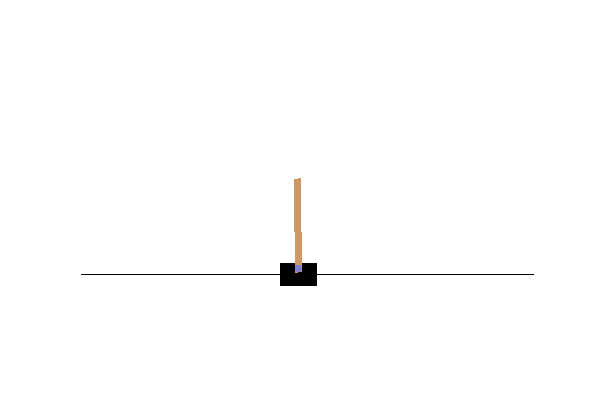
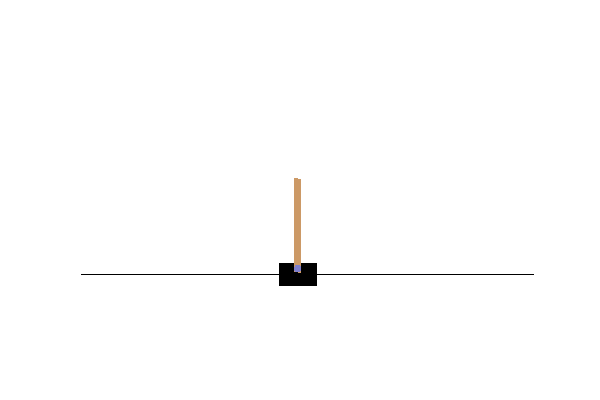
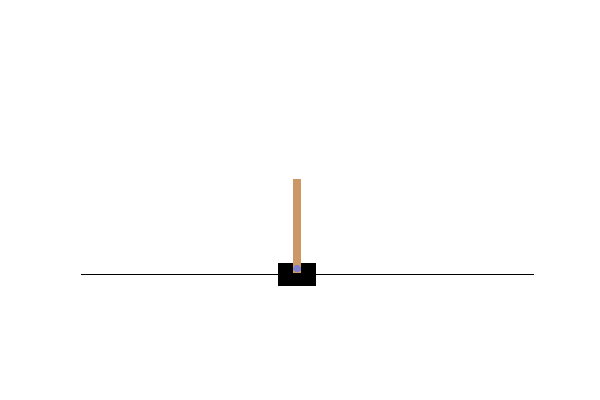
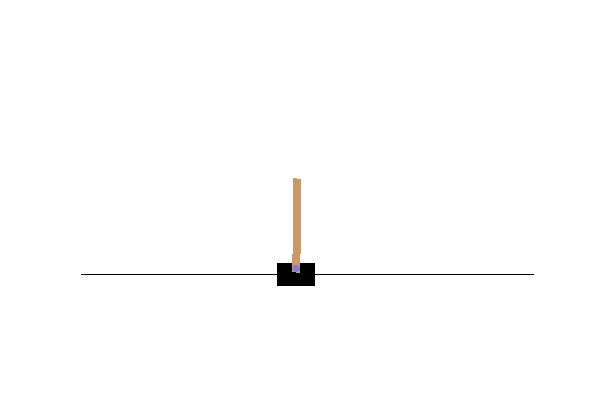
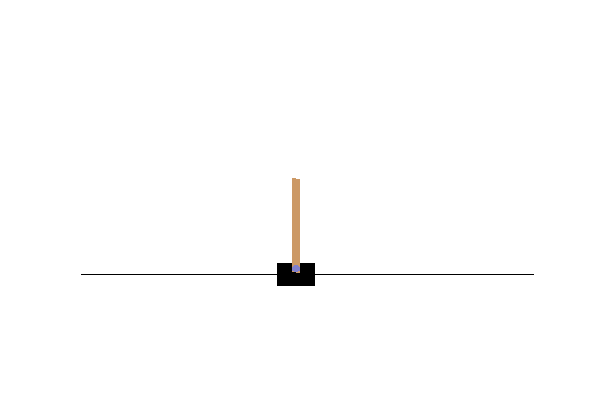
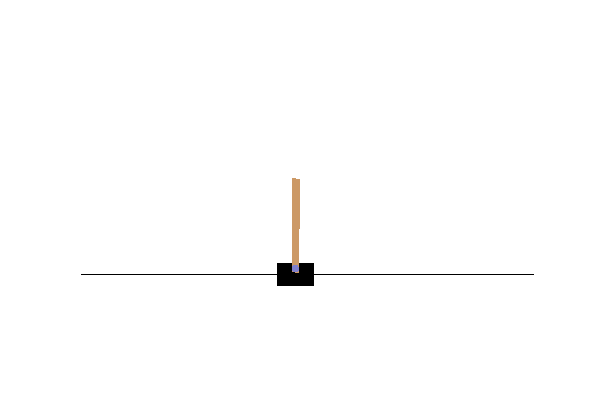
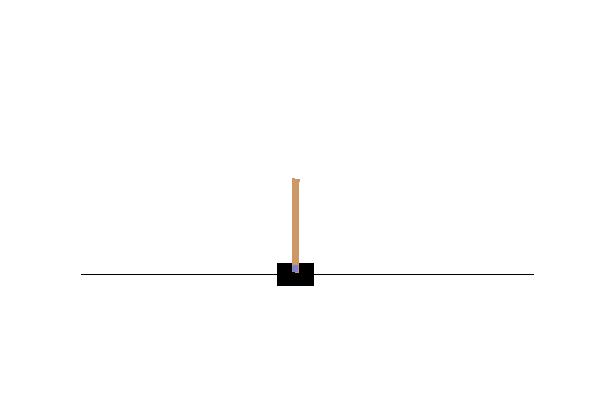
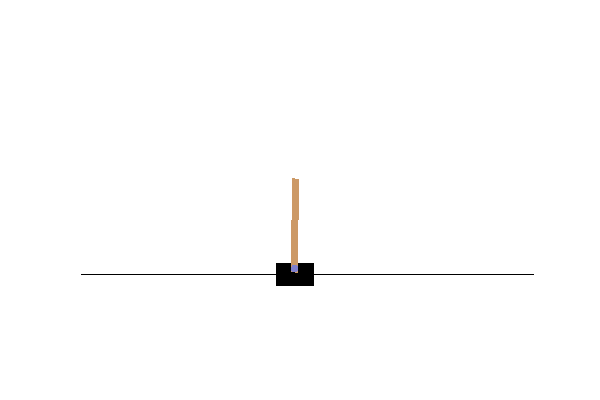
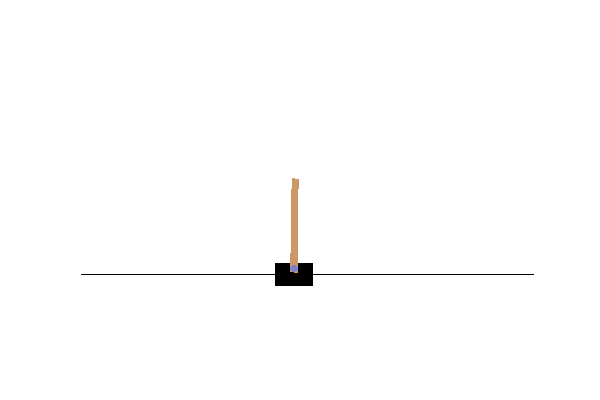
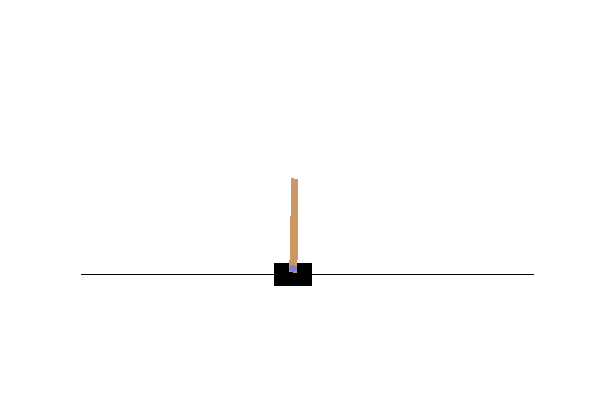
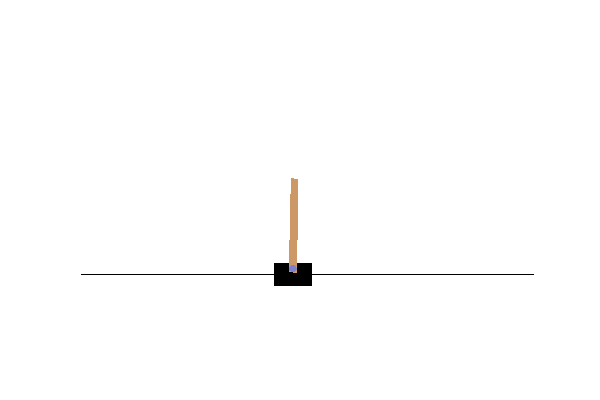
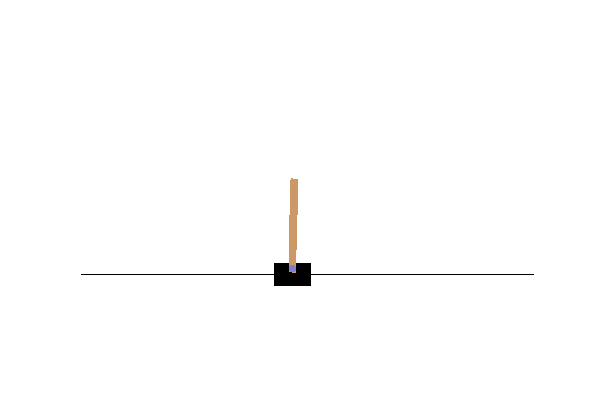
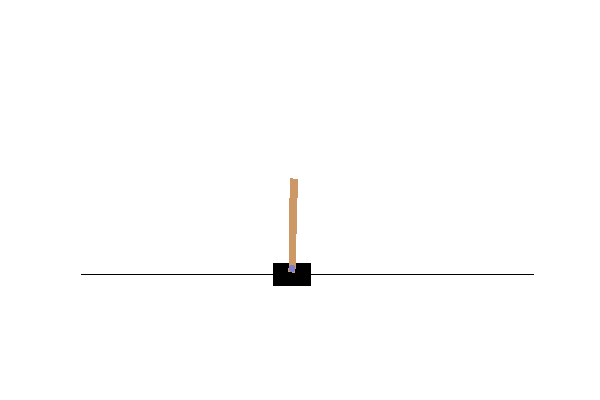
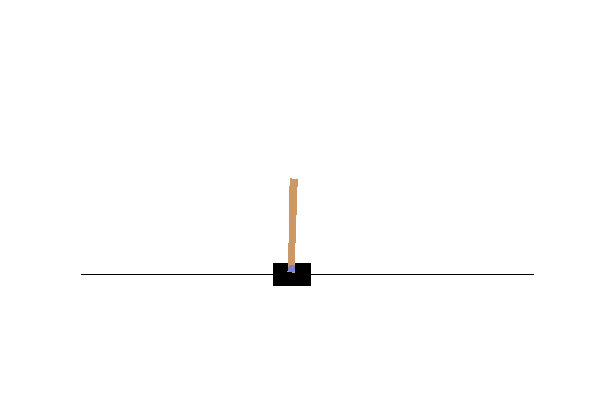
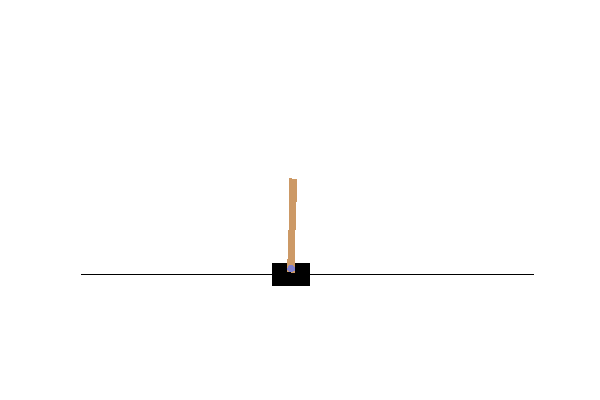
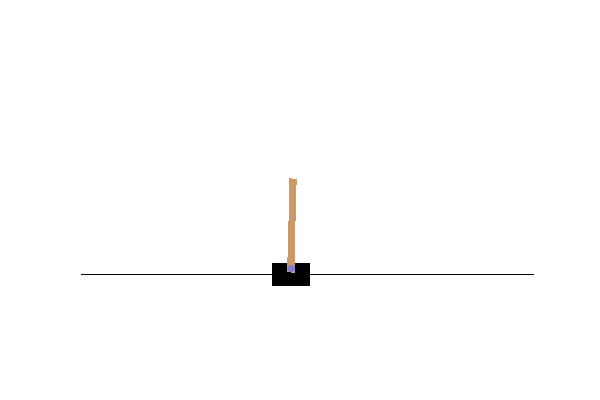
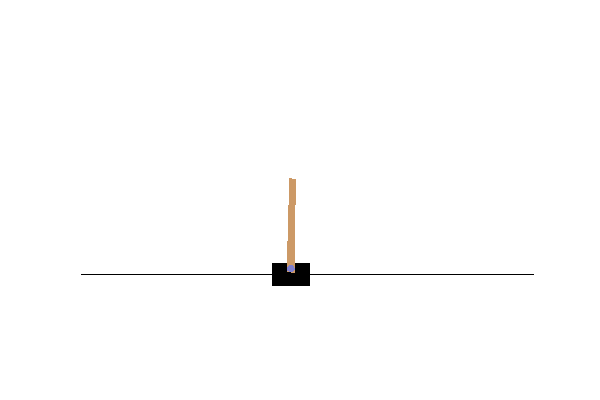
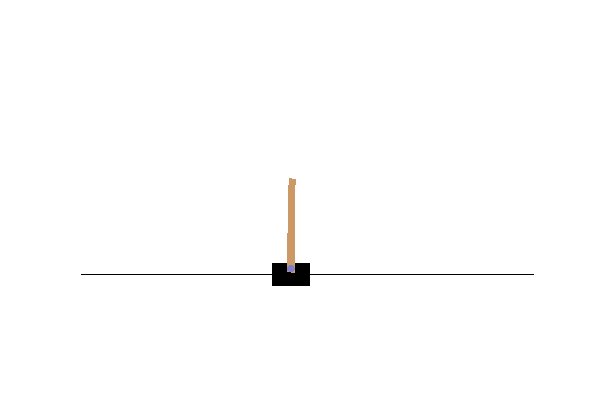
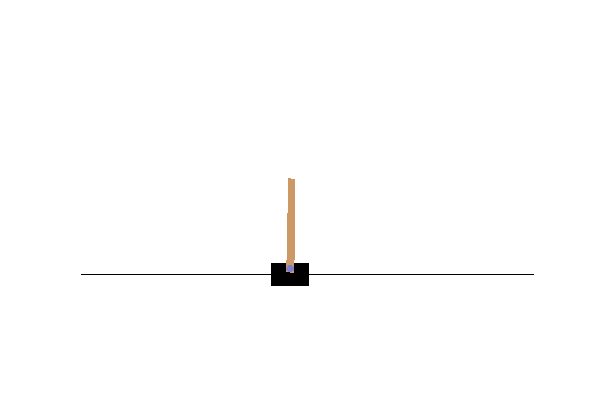
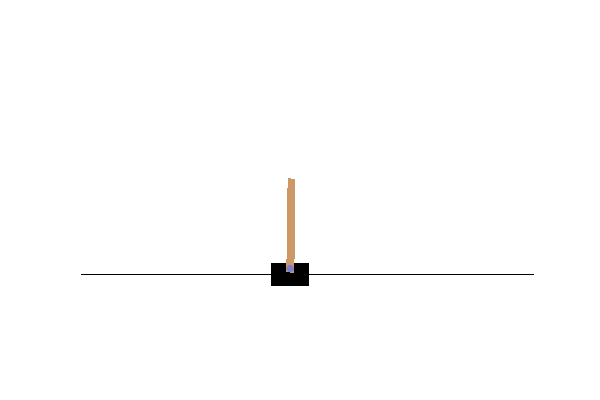
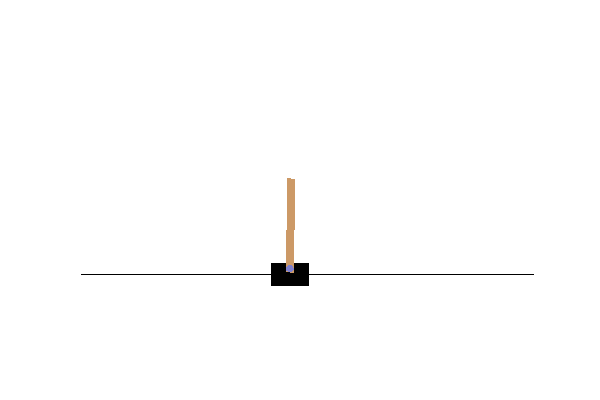
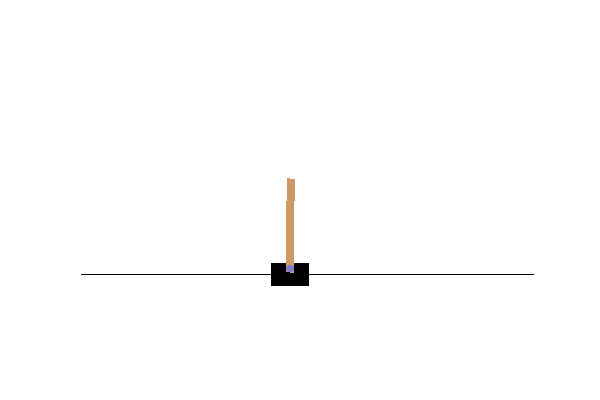
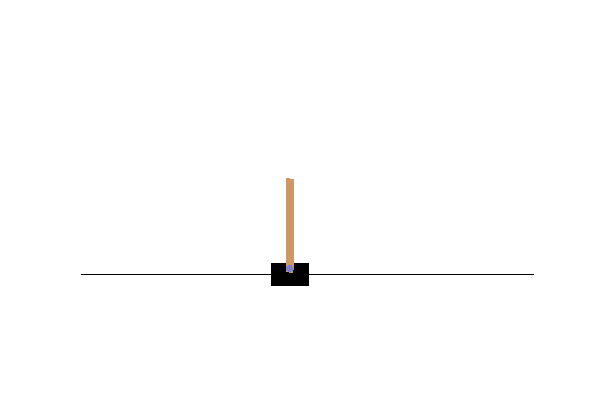
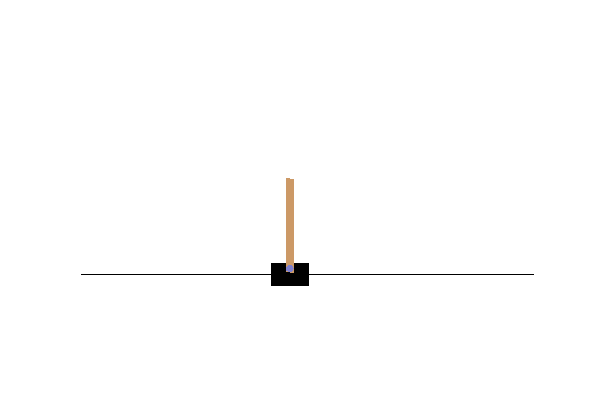
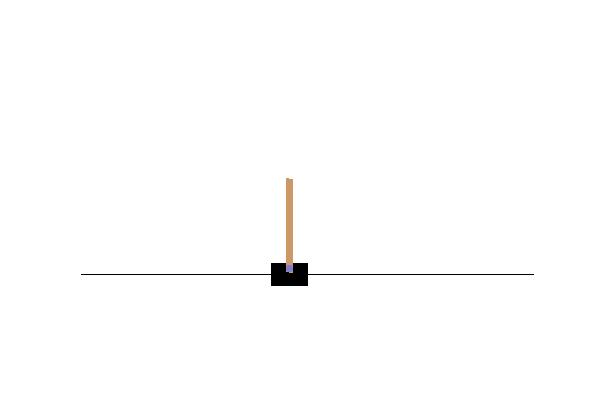
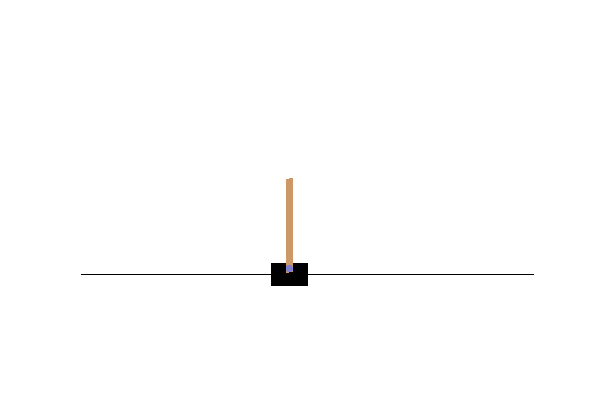
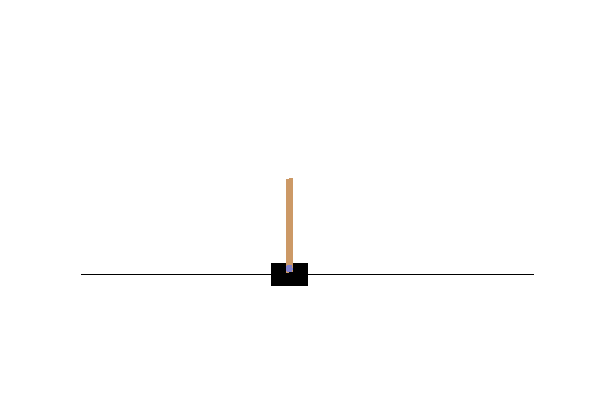
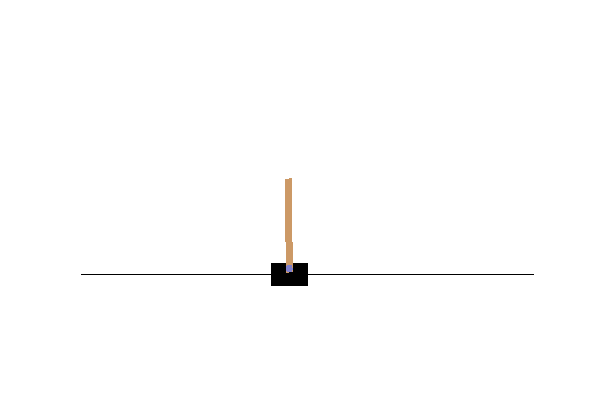
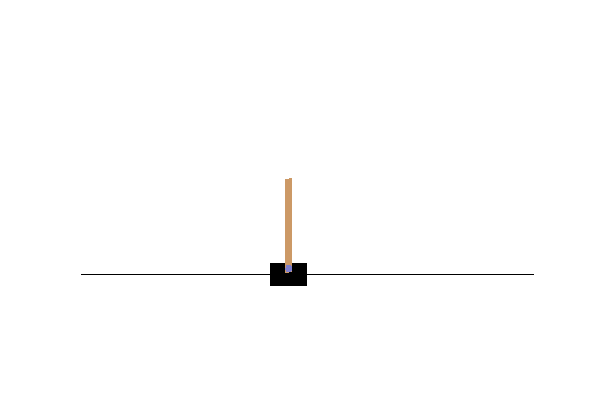
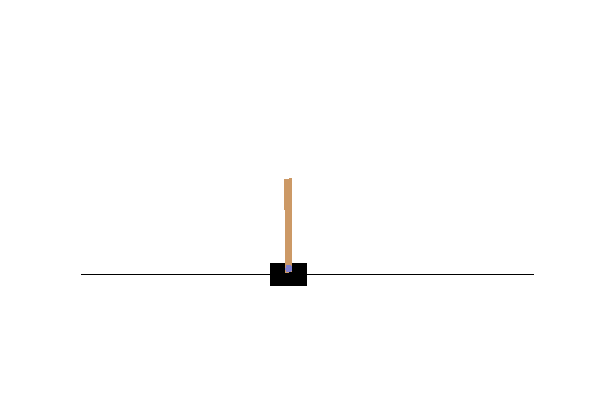
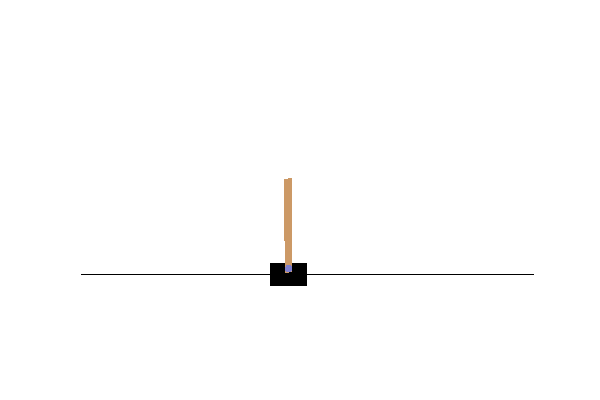
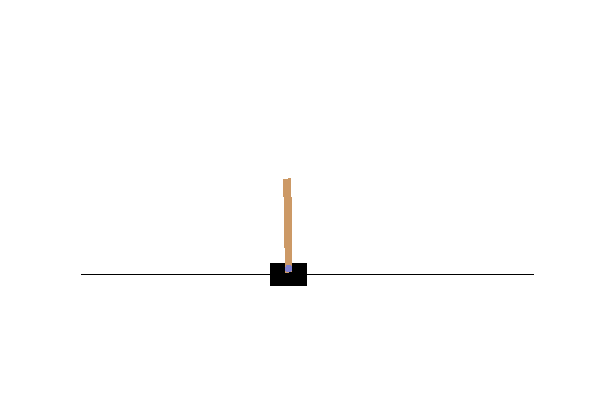
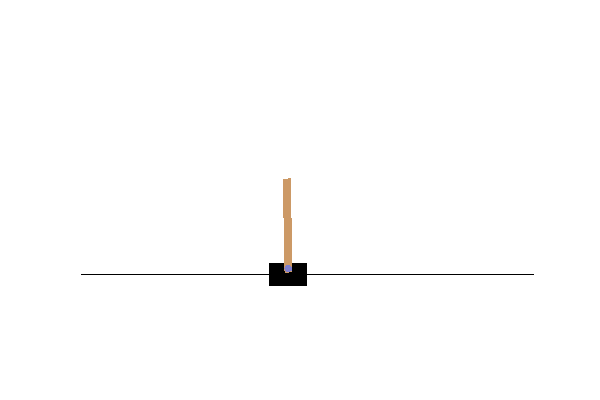
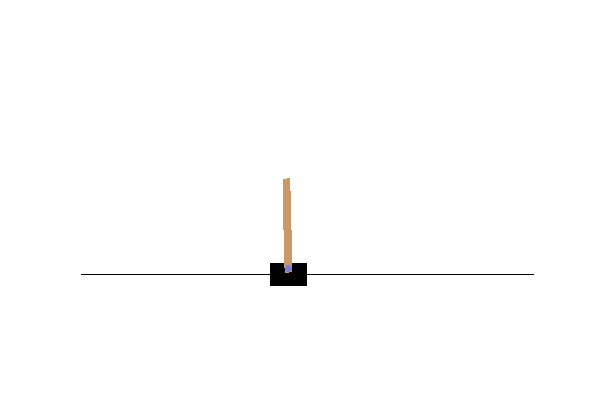
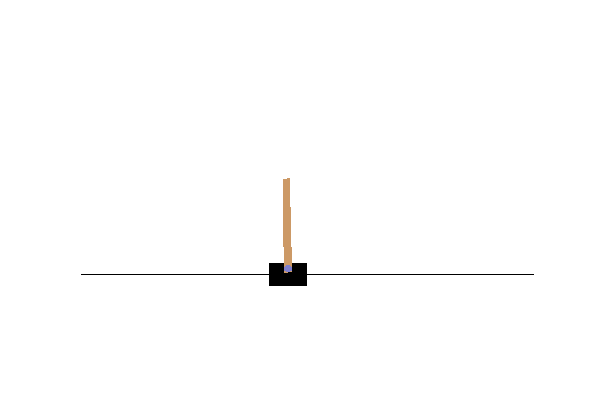
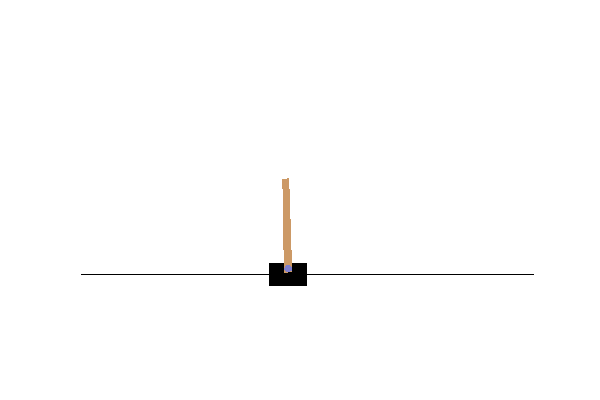
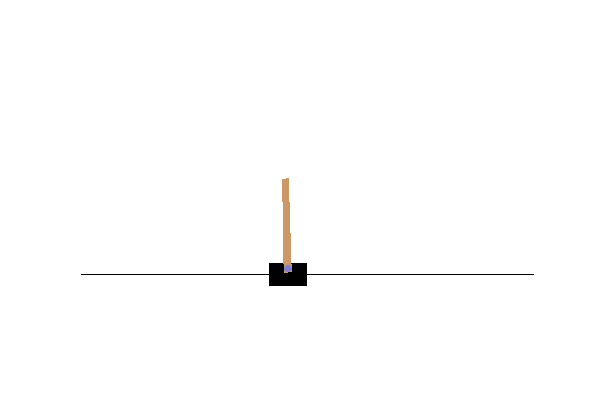
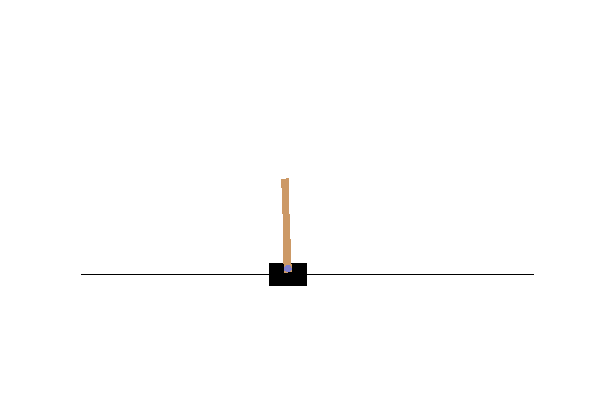
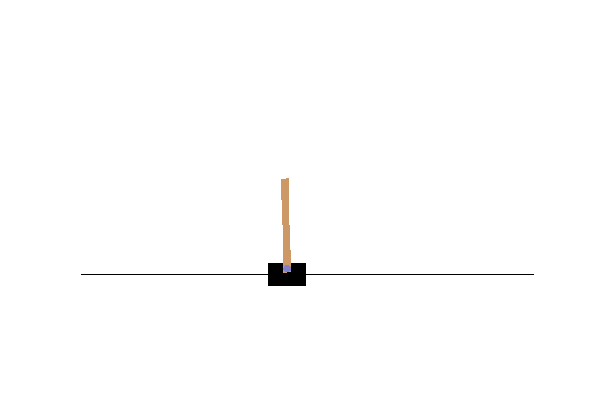
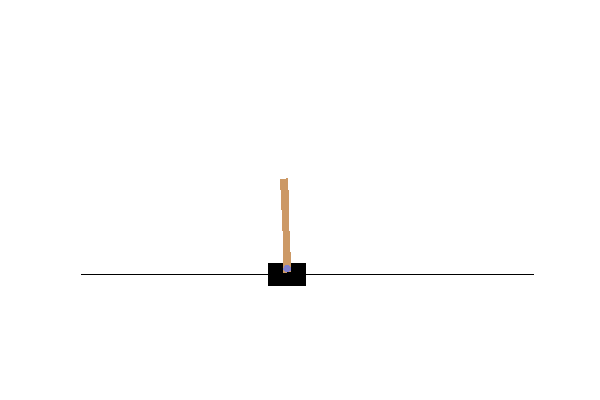
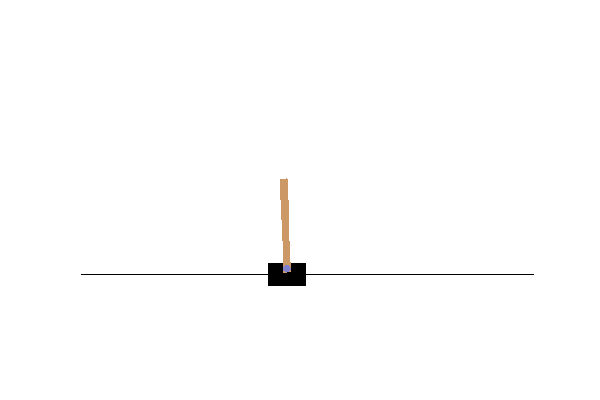
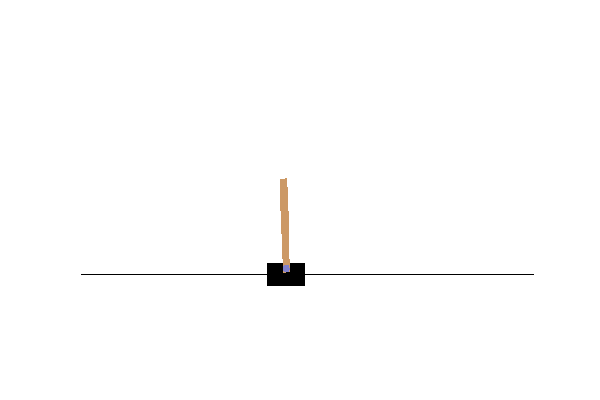
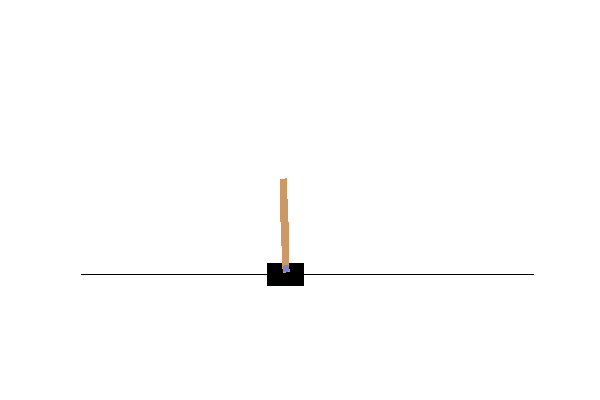
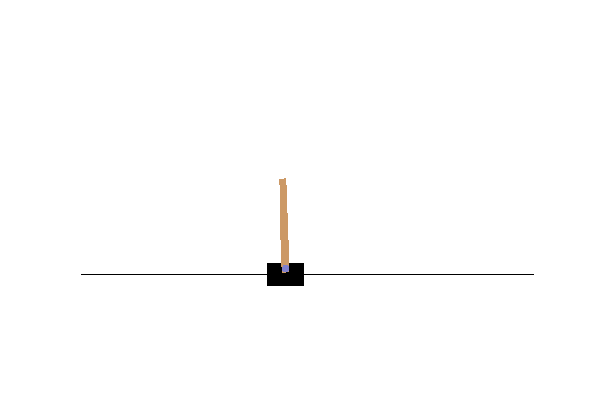
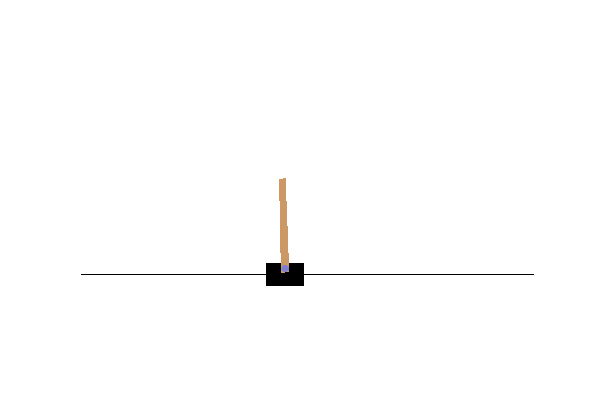
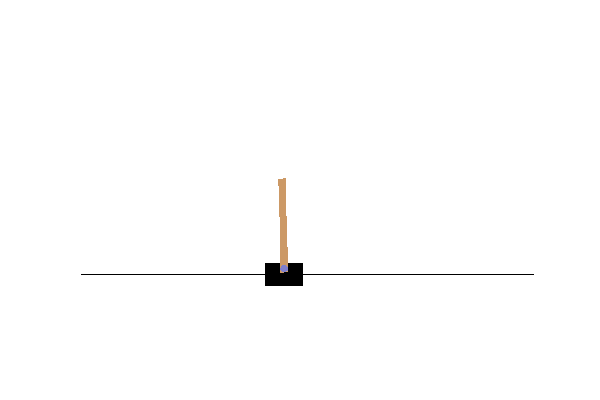
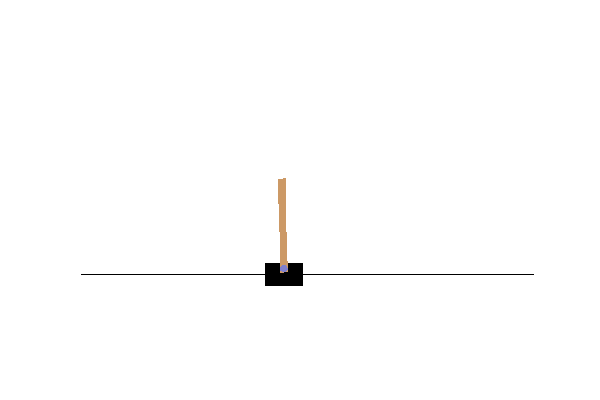
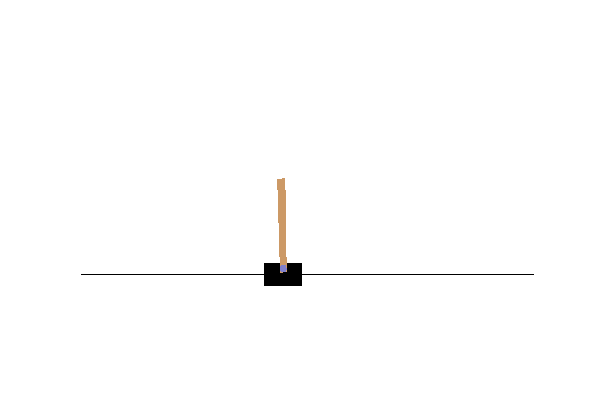
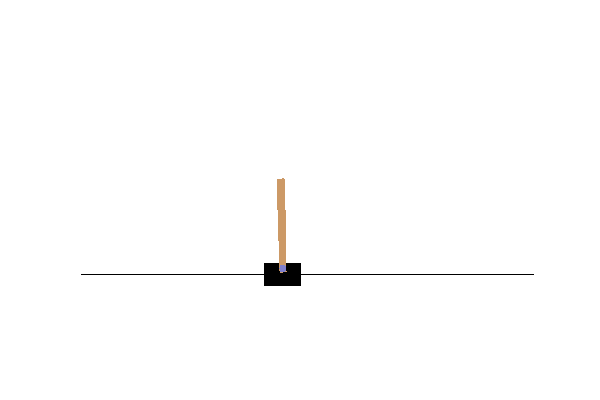
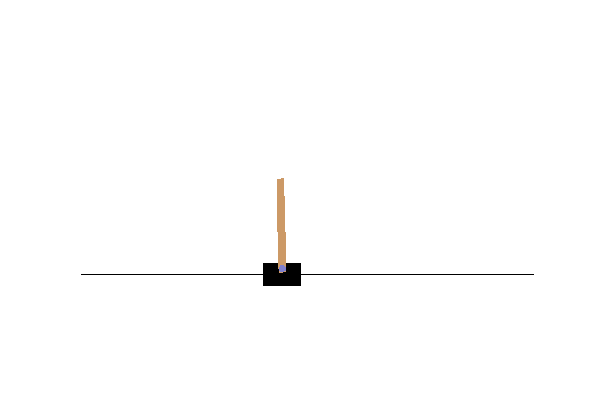
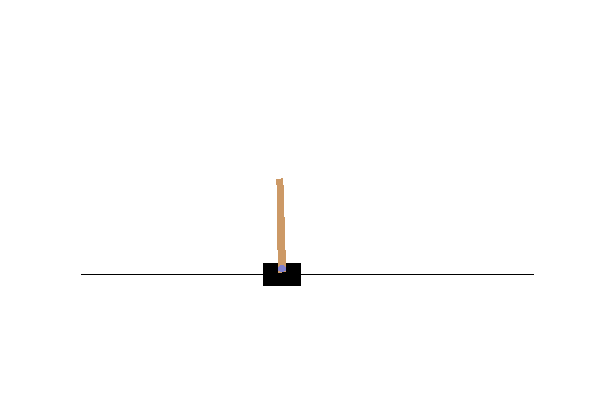
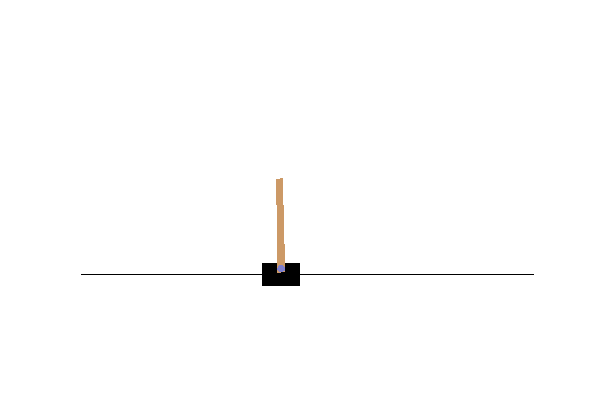
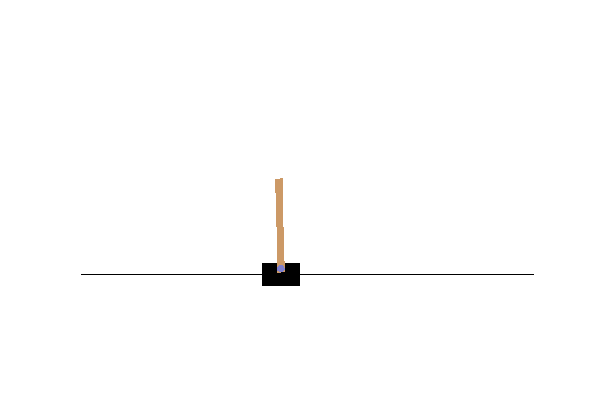
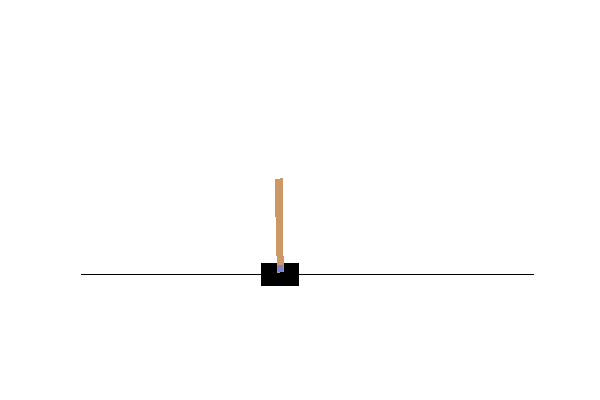
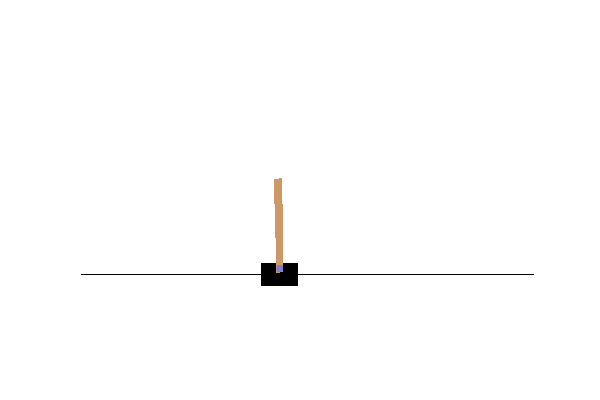
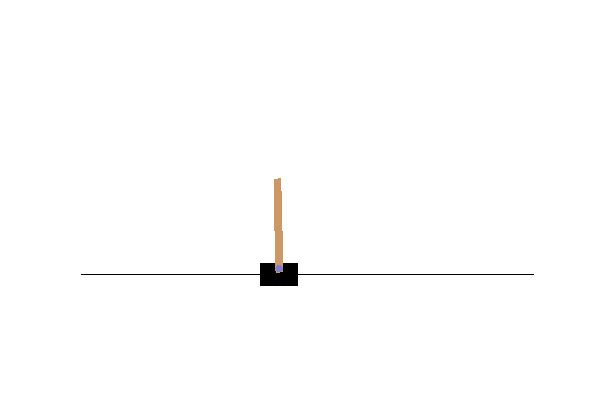
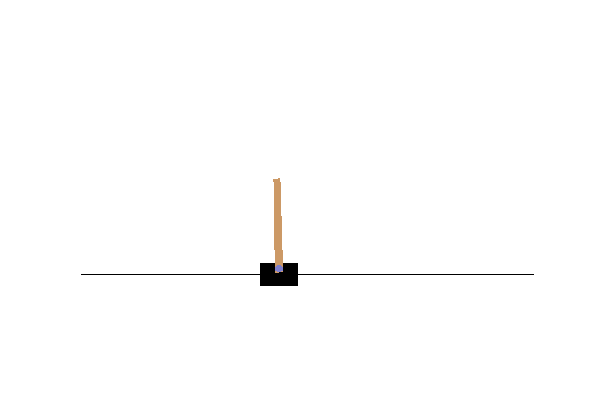
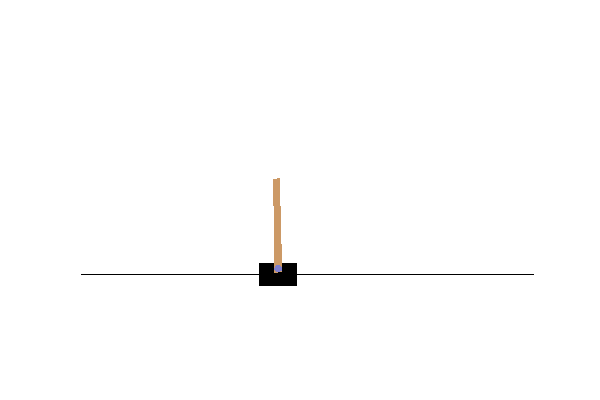
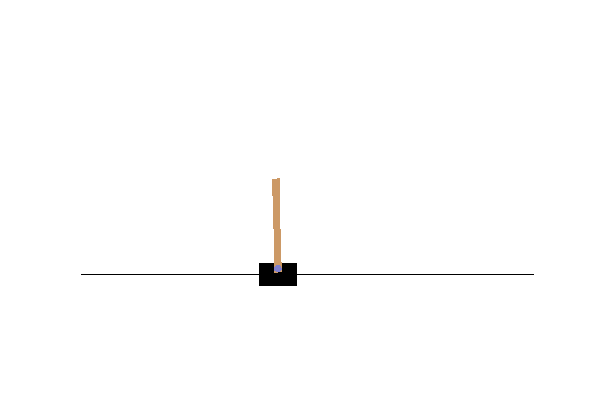
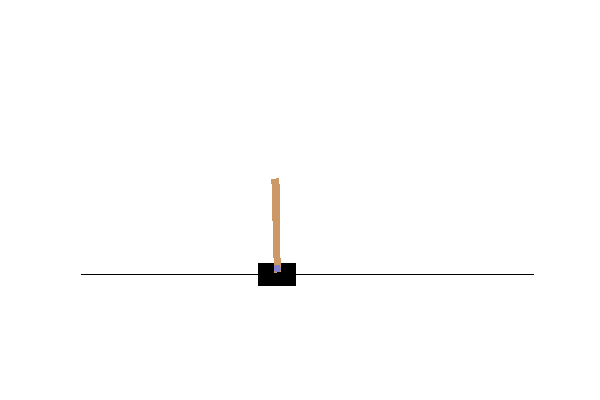
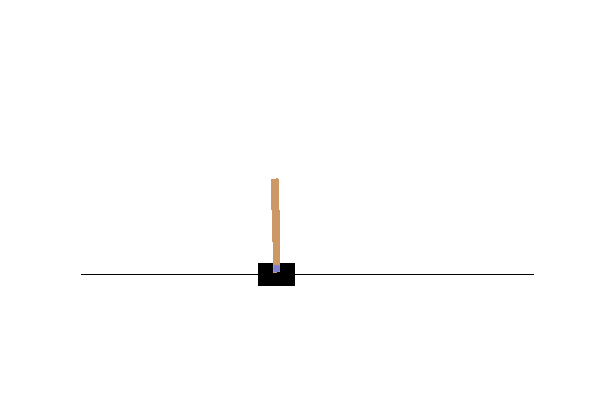
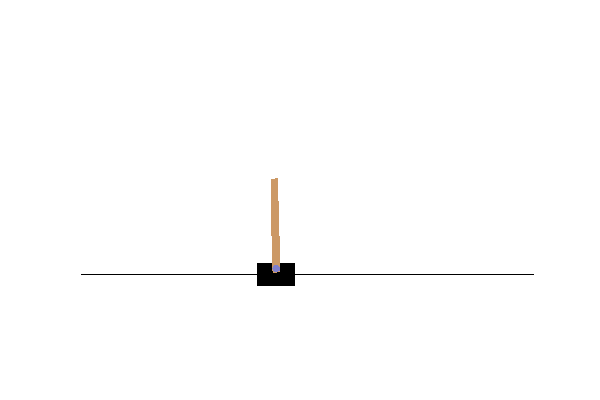
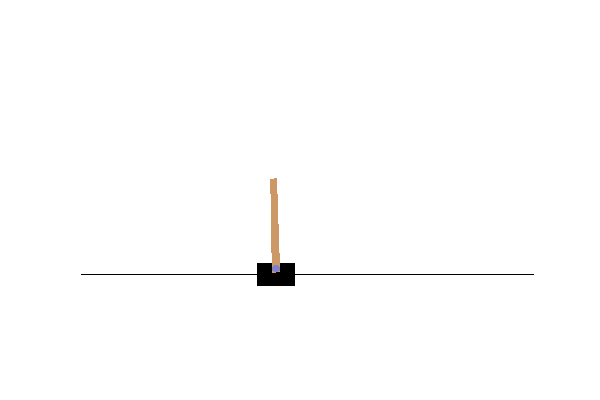
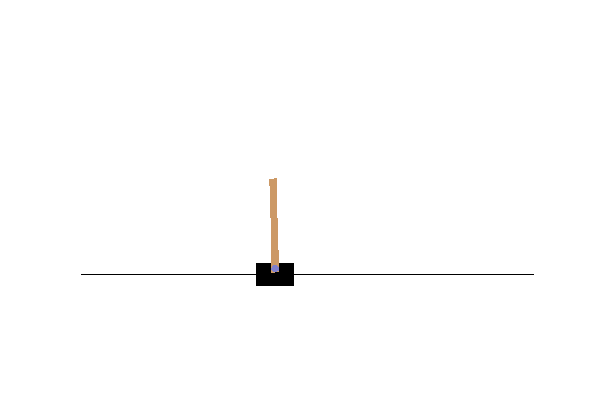
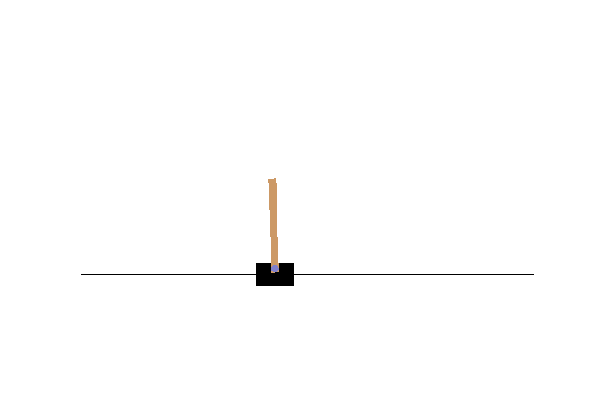
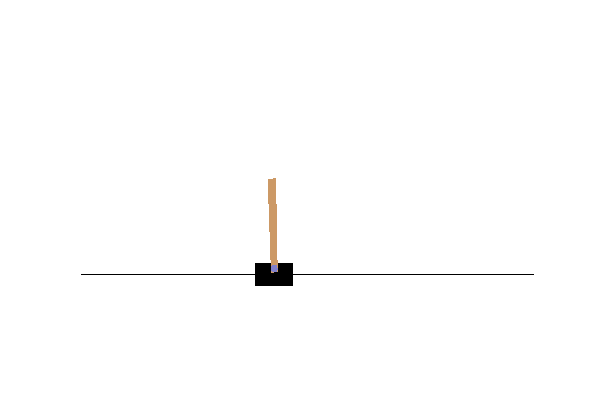

In [18]:
# main 類別
cartpole_env = Environment()
cartpole_env.run()
